# Comparative Analysis of Twitter Ego Networks

This notebook performs a comparative analysis of ego networks with fewer graphs and more comparative tables (saved as CSVs).

In [1]:
# Import Required Libraries
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib
matplotlib.use('Agg')  # non-interactive backend
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load All Twitter Ego Networks

Identify ego networks and load components.

In [2]:
# Define the path to the Twitter ego networks
twitter_path = "twitter_ego/twitter"

# Output folder for summary tables/plots
summary_dir = Path(twitter_path) / "summary_tables"
summary_dir.mkdir(parents=True, exist_ok=True)

# Find all unique node IDs by looking for .edges files
ego_network_ids = []
if os.path.exists(twitter_path):
    for file in os.listdir(twitter_path):
        if file.endswith('.edges'):
            node_id = file.replace('.edges', '')
            ego_network_ids.append(node_id)
    ego_network_ids.sort()
    print(f"Found {len(ego_network_ids)} ego networks")
else:
    print(f"Directory {twitter_path} not found!")

Found 973 ego networks


In [3]:
# Function to load an ego network
def load_ego_network(node_id, twitter_path="twitter_ego/twitter"):
    data = {}
    edges_file = f"{twitter_path}/{node_id}.edges"
    if os.path.exists(edges_file):
        try:
            data['edges'] = pd.read_csv(edges_file, sep=r"\s+", header=None, names=['source','target'], engine='python')
        except Exception:
            data['edges'] = pd.read_csv(edges_file, sep=' ', header=None, names=['source','target'])
    else:
        data['edges'] = pd.DataFrame(columns=['source','target'])
    
    feat_file = f"{twitter_path}/{node_id}.feat"
    if os.path.exists(feat_file):
        data['feat'] = pd.read_csv(feat_file, sep=r"\s+", header=None, engine='python')
    else:
        data['feat'] = None
    
    egofeat_file = f"{twitter_path}/{node_id}.egofeat"
    if os.path.exists(egofeat_file):
        data['egofeat'] = pd.read_csv(egofeat_file, sep=r"\s+", header=None, engine='python')
    else:
        data['egofeat'] = None
    
    circles_file = f"{twitter_path}/{node_id}.circles"
    circles = {}
    if os.path.exists(circles_file):
        with open(circles_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                circles[parts[0]] = parts[1:] if len(parts) > 1 else []
    data['circles'] = circles
    return data

# Load all ego networks (small log)
all_networks = {}
for node_id in ego_network_ids:
    all_networks[node_id] = load_ego_network(node_id, twitter_path=twitter_path)
    print(f"Loaded network {node_id}: {len(all_networks[node_id]['edges'])} edges, {len(all_networks[node_id]['circles'])} circles")

Loaded network 100318079: 8354 edges, 4 circles
Loaded network 10146102: 951 edges, 1 circles
Loaded network 101859065: 208 edges, 4 circles
Loaded network 101903164: 51 edges, 2 circles
Loaded network 102765423: 1070 edges, 3 circles
Loaded network 102903198: 4925 edges, 1 circles
Loaded network 103431502: 473 edges, 2 circles
Loaded network 103865085: 2484 edges, 2 circles
Loaded network 103991905: 615 edges, 2 circles
Loaded network 104324908: 77 edges, 2 circles
Loaded network 104615636: 506 edges, 3 circles
Loaded network 1046661: 1642 edges, 7 circles
Loaded network 104991493: 2419 edges, 5 circles
Loaded network 105150583: 4795 edges, 5 circles
Loaded network 105398724: 166 edges, 2 circles
Loaded network 105918870: 2849 edges, 7 circles
Loaded network 107172099: 285 edges, 2 circles
Loaded network 107418464: 1739 edges, 2 circles
Loaded network 107511013: 294 edges, 0 circles
Loaded network 107512718: 2322 edges, 17 circles
Loaded network 107516840: 7160 edges, 5 circles
Loaded

## 2. Build Graphs and Extract Basic Stats

Construct NetworkX graphs and compute basic statistics; save as CSVs.

In [4]:
# Build graphs
def build_ego_graph(node_id, network_data):
    G = nx.DiGraph()
    edges = network_data.get('edges', pd.DataFrame(columns=['source','target']))
    if not edges.empty:
        G.add_edges_from(edges.values)
    G.add_node(node_id)
    neighbors = set()
    if not edges.empty:
        neighbors = set(edges['source'].tolist()) | set(edges['target'].tolist())
    for n in neighbors:
        G.add_edge(node_id, n)
    return G

graphs = {}
for node_id, network_data in all_networks.items():
    graphs[node_id] = build_ego_graph(node_id, network_data)

# Compute basic stats
def compute_basic_stats(G):
    stats = {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'is_connected': nx.is_weakly_connected(G) if G.number_of_nodes()>0 else False,
    }
    try:
        stats['num_scc'] = nx.number_strongly_connected_components(G)
        stats['num_wcc'] = nx.number_weakly_connected_components(G)
    except Exception:
        stats['num_scc'] = 0
        stats['num_wcc'] = 0
    return stats

network_stats = {nid: compute_basic_stats(G) for nid, G in graphs.items()}
stats_df = pd.DataFrame(network_stats).T
stats_df.index.name = 'network_id'
print('Basic Network Statistics (first rows):')
display(stats_df.head())
# Save
stats_df.to_csv(summary_dir / 'basic_stats.csv')

Basic Network Statistics (first rows):


,num_nodes,num_edges,density,is_connected,num_scc,num_wcc
network_id,,,,,,
100318079,221,8574,0.176347,True,4,1
10146102,96,1046,0.114693,True,12,1
101859065,24,231,0.418478,True,3,1
101903164,15,65,0.309524,True,4,1
102765423,85,1154,0.161625,True,9,1


## 3. Degree Statistics (tables)

Compute degree statistics for each network and save results.

In [5]:
# Compute degree statistics
def compute_degree_stats(G):
    in_degrees = [d for _, d in G.in_degree()]
    out_degrees = [d for _, d in G.out_degree()]
    if len(in_degrees)==0: in_degrees=[0]
    if len(out_degrees)==0: out_degrees=[0]
    stats = {
        'mean_in_degree': float(np.mean(in_degrees)),
        'median_in_degree': float(np.median(in_degrees)),
        'max_in_degree': int(np.max(in_degrees)),
        'std_in_degree': float(np.std(in_degrees)),
        'mean_out_degree': float(np.mean(out_degrees)),
        'median_out_degree': float(np.median(out_degrees)),
        'max_out_degree': int(np.max(out_degrees)),
        'std_out_degree': float(np.std(out_degrees)),
    }
    return stats, in_degrees, out_degrees

degree_stats = {}
degree_distributions = {}
for nid, G in graphs.items():
    st, ind, outd = compute_degree_stats(G)
    degree_stats[nid] = st
    degree_distributions[nid] = {'in': ind, 'out': outd}
degree_stats_df = pd.DataFrame(degree_stats).T
degree_stats_df.index.name = 'network_id'
print('Degree statistics (first rows):')
display(degree_stats_df.head())
degree_stats_df.to_csv(summary_dir / 'degree_stats.csv')

Degree statistics (first rows):


,mean_in_degree,median_in_degree,max_in_degree,std_in_degree,mean_out_degree,median_out_degree,max_out_degree,std_out_degree
network_id,,,,,,,,
100318079,38.796380,27.0,175.0,34.071381,38.796380,32.0,220.0,32.664885
10146102,10.895833,10.0,36.0,7.297944,10.895833,9.0,95.0,11.489560
101859065,9.625000,8.0,18.0,4.599026,9.625000,8.0,23.0,5.483403
101903164,4.333333,5.0,9.0,2.599145,4.333333,3.0,14.0,3.438346
102765423,13.576471,9.0,59.0,12.353972,13.576471,9.0,84.0,13.205504


## 4. Clustering Coefficients (tables)

Compute clustering stats and save results.

In [6]:
def compute_clustering_stats(G):
    G_undirected = G.to_undirected()
    if G_undirected.number_of_nodes() == 0:
        return {
            'avg_clustering': 0.0, 'transitivity': 0.0, 'max_clustering': 0.0, 'min_clustering': 0.0, 'std_clustering': 0.0
        }, []
    try:
        avg_clustering = nx.average_clustering(G_undirected)
    except Exception:
        avg_clustering = 0.0
    try:
        transitivity = nx.transitivity(G_undirected)
    except Exception:
        transitivity = 0.0
    clustering_coeffs = list(nx.clustering(G_undirected).values())
    stats = {
        'avg_clustering': float(avg_clustering),
        'transitivity': float(transitivity),
        'max_clustering': float(np.max(clustering_coeffs)) if clustering_coeffs else 0.0,
        'min_clustering': float(np.min(clustering_coeffs)) if clustering_coeffs else 0.0,
        'std_clustering': float(np.std(clustering_coeffs)) if clustering_coeffs else 0.0
    }
    return stats, clustering_coeffs

clustering_stats = {}
clustering_distributions = {}
for nid, G in graphs.items():
    st, coeffs = compute_clustering_stats(G)
    clustering_stats[nid] = st
    clustering_distributions[nid] = coeffs
clustering_df = pd.DataFrame(clustering_stats).T
clustering_df.index.name = 'network_id'
print('Clustering stats (first rows):')
display(clustering_df.head())
clustering_df.to_csv(summary_dir / 'clustering_stats.csv')

Clustering stats (first rows):


,avg_clustering,transitivity,max_clustering,min_clustering,std_clustering
network_id,,,,,
100318079,0.616636,0.560765,1.0,0.247862,0.144841
10146102,0.583678,0.378358,1.0,0.142889,0.176623
101859065,0.788856,0.707054,1.0,0.569170,0.133865
101903164,0.805493,0.595174,1.0,0.395604,0.211975
102765423,0.624577,0.498334,1.0,0.223752,0.163678


## 5. Comprehensive Table

Combine all metrics into a single comprehensive dataframe and save to CSV. Prefer tables over multiple dashboards.

In [7]:
comprehensive_df = stats_df.copy()
comprehensive_df = comprehensive_df.join(degree_stats_df, how='left')
comprehensive_df = comprehensive_df.join(clustering_df, how='left')
comprehensive_df['avg_degree'] = (comprehensive_df['mean_in_degree'] + comprehensive_df['mean_out_degree']) / 2

# Ensure index dtype
comprehensive_df.index = comprehensive_df.index.map(str)
print('Comprehensive metrics (first rows):')
display(comprehensive_df.head())
comprehensive_df.to_csv(summary_dir / 'comprehensive_metrics.csv')

Comprehensive metrics (first rows):


,num_nodes,num_edges,density,is_connected,num_scc,num_wcc,mean_in_degree,median_in_degree,max_in_degree,std_in_degree,mean_out_degree,median_out_degree,max_out_degree,std_out_degree,avg_clustering,transitivity,max_clustering,min_clustering,std_clustering,avg_degree
network_id,,,,,,,,,,,,,,,,,,,,
100318079,221,8574,0.176347,True,4,1,38.796380,27.0,175.0,34.071381,38.796380,32.0,220.0,32.664885,0.616636,0.560765,1.0,0.247862,0.144841,38.796380
10146102,96,1046,0.114693,True,12,1,10.895833,10.0,36.0,7.297944,10.895833,9.0,95.0,11.489560,0.583678,0.378358,1.0,0.142889,0.176623,10.895833
101859065,24,231,0.418478,True,3,1,9.625000,8.0,18.0,4.599026,9.625000,8.0,23.0,5.483403,0.788856,0.707054,1.0,0.569170,0.133865,9.625000
101903164,15,65,0.309524,True,4,1,4.333333,5.0,9.0,2.599145,4.333333,3.0,14.0,3.438346,0.805493,0.595174,1.0,0.395604,0.211975,4.333333
102765423,85,1154,0.161625,True,9,1,13.576471,9.0,59.0,12.353972,13.576471,9.0,84.0,13.205504,0.624577,0.498334,1.0,0.223752,0.163678,13.576471


## 6. Outlier Detection (tables)

Identify outliers via z-score and save the results.

In [8]:
from scipy import stats
def identify_outliers(df, columns, threshold=1.5):
    outliers = {}
    for col in columns:
        if col not in df.columns:
            continue
        col_vals = df[col].astype(float).values
        z_scores = np.abs((col_vals - np.nanmean(col_vals)) / (np.nanstd(col_vals) if np.nanstd(col_vals)!=0 else 1e-8))
        mask = z_scores > threshold
        if mask.any():
            nets = df.index[mask].tolist()
            vals = df.loc[nets, col].tolist()
            zs = z_scores[mask].tolist()
            outliers[col] = {'networks': nets, 'values': vals, 'z_scores': zs}
    return outliers

metrics_to_check = ['num_nodes', 'num_edges', 'density', 'avg_degree', 'avg_clustering', 'transitivity']
outliers = identify_outliers(comprehensive_df, metrics_to_check, threshold=1.5)
print('Outliers summary:')
out_rows = []
for metric, data in outliers.items():
    for net, val, z in zip(data['networks'], data['values'], data['z_scores']):
        out_rows.append({'metric': metric, 'network': net, 'value': val, 'z_score': z})
outliers_df = pd.DataFrame(out_rows)
display(outliers_df.head())
outliers_df.to_csv(summary_dir / 'outliers_flat.csv', index=False)
import json
with open(summary_dir / 'outliers.json', 'w') as f:
    json.dump(outliers, f, indent=2)

Outliers summary:


,metric,network,value,z_score
0,num_nodes,101859065,24.0,1.687679
1,num_nodes,101903164,15.0,1.827339
2,num_nodes,104324908,14.0,1.842857
3,num_nodes,105398724,22.0,1.718714
4,num_nodes,107172099,24.0,1.687679


## 7. Clustering (tables) and minimal plotting

Perform clustering, save assignments and cluster summary. Optionally produce one heatmap (correlation).

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

clustering_features = [c for c in ['num_nodes','num_edges','density','avg_degree','avg_clustering','transitivity'] if c in comprehensive_df.columns]
if len(comprehensive_df) >= 2 and len(clustering_features) >= 2:
    scaler = StandardScaler()
    X = comprehensive_df[clustering_features].astype(float).fillna(0)
    X_scaled = scaler.fit_transform(X)
    optimal_k = min(3, max(2, len(comprehensive_df)//2))
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    comprehensive_df['cluster'] = labels
    comprehensive_df.to_csv(summary_dir / 'comprehensive_with_clusters.csv')
    # cluster summary table
    cluster_summary = comprehensive_df.groupby('cluster')[clustering_features].agg(['mean','std','count'])
    display(cluster_summary)
    cluster_summary.to_csv(summary_dir / 'cluster_summary.csv')
    # save PCA coords
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(pca_coords, index=comprehensive_df.index, columns=['PC1','PC2'])
    pca_df.to_csv(summary_dir / 'pca_coords.csv')
else:
    comprehensive_df['cluster'] = 0
    comprehensive_df.to_csv(summary_dir / 'comprehensive_with_clusters.csv')
    cluster_summary = comprehensive_df.groupby('cluster')[clustering_features].agg(['mean','std','count'])
    cluster_summary.to_csv(summary_dir / 'cluster_summary.csv')
    display(cluster_summary.head())

num_nodes                     num_edges                     \
               mean        std count         mean          std count   
cluster                                                                
0        124.030992  52.109308   484  1360.427686   832.779489   484   
1         56.413043  31.673075   184  1150.168478  1224.357389   184   
2        192.662295  33.527493   305   5065.67541  2018.644884   305   

          density                 avg_degree                 avg_clustering  \
             mean       std count       mean       std count           mean   
cluster                                                                       
0        0.093115  0.039204   484  10.251880  3.986632   484       0.634833   
1         0.31709  0.121365   184  15.997337  9.645128   184       0.758261   
2        0.142873  0.055929   305  26.380026  9.152414   305       0.607463   

                        transitivity                  
              std count         mean       std count  
cluster                                               
0        0.063395   484     0.365091  0.098708   484  
1        0.062439   184     0.651811  0.101639   184  
2        0.051441   305     0.476164  0.078913   305

## 8. Typical vs Unusual Networks (tables)

Classify networks by distance from mean and save lists and summary tables.

In [10]:
mean_values = comprehensive_df[clustering_features].mean() if len(clustering_features)>0 else pd.Series()
std_values = comprehensive_df[clustering_features].std().replace(0, 1e-8) if len(clustering_features)>0 else pd.Series()
distances = []
for idx in comprehensive_df.index:
    if len(clustering_features)==0:
        distances.append(0.0)
        continue
    network_values = comprehensive_df.loc[idx, clustering_features]
    z_scores = (network_values - mean_values) / std_values
    distance = np.sqrt((z_scores.fillna(0) ** 2).sum())
    distances.append(distance)
comprehensive_df['distance_from_mean'] = distances
comprehensive_df['is_typical'] = comprehensive_df['distance_from_mean'] < np.nanmedian(comprehensive_df['distance_from_mean'])
typical_networks = comprehensive_df[comprehensive_df['is_typical']].index.tolist()
unusual_networks = comprehensive_df[~comprehensive_df['is_typical']].index.tolist()
pd.Series(typical_networks).to_csv(summary_dir / 'typical_networks.csv', index=False, header=False)
pd.Series(unusual_networks).to_csv(summary_dir / 'unusual_networks.csv', index=False, header=False)
print(f'Typical networks ({len(typical_networks)}): {typical_networks}')
print(f'Unusual networks ({len(unusual_networks)}): {unusual_networks}')
display(comprehensive_df[[*clustering_features, 'distance_from_mean', 'is_typical']].head())
comprehensive_df.to_csv(summary_dir / 'comprehensive_final.csv')

Typical networks (486): ['10146102', '102765423', '103865085', '103991905', '1046661', '104991493', '105150583', '105918870', '107418464', '107512718', '10798802', '11027262', '110755733', '111045742', '11136132', '111374622', '112628165', '113196940', '11348722', '114115460', '114885421', '115221382', '116798290', '11681802', '117029850', '117671022', '117800618', '117809922', '11784842', '12069912', '120971873', '12152402', '121569946', '121685268', '123684709', '12415722', '124296976', '125098615', '12570812', '12771872', '127912925', '129093262', '13179562', '13212502', '132519763', '13275962', '13317162', '134208594', '13460312', '135605269', '13649212', '137046366', '13747362', '13872872', '14045302', '14058831', '14077024', '14120253', '14147754', '141488457', '14191254', '14203895', '14313005', '143172151', '14332288', '143344048', '14365883', '143661263', '14371740', '14372763', '14404235', '144211337', '14521330', '14528221', '14550962', '14618160', '14755105', '14791232', '1

,num_nodes,num_edges,density,avg_degree,avg_clustering,transitivity,distance_from_mean,is_typical
network_id,,,,,,,,
100318079,221,8574,0.176347,38.796380,0.616636,0.560765,3.883064,False
10146102,96,1046,0.114693,10.895833,0.583678,0.378358,1.452719,True
101859065,24,231,0.418478,9.625000,0.788856,0.707054,4.091499,False
101903164,15,65,0.309524,4.333333,0.805493,0.595174,3.589911,False
102765423,85,1154,0.161625,13.576471,0.624577,0.498334,1.088896,True


In [11]:
# --- Select best networks based on analysis ---
import numpy as np

metrics = [c for c in ['num_nodes','num_edges','density','avg_degree','avg_clustering','transitivity'] if c in comprehensive_df.columns]
rank_df = comprehensive_df.copy()

if len(metrics) > 0:
    z = (rank_df[metrics].astype(float).fillna(0) - rank_df[metrics].mean()) / rank_df[metrics].std().replace(0, 1e-8)
    for m in metrics:
        rank_df[f'z_{m}'] = z[m]
    # composite score: sum of absolute z-scores (higher => more atypical)
    rank_df['composite_score'] = z.abs().sum(axis=1)
else:
    rank_df['composite_score'] = 0

# ensure distance_from_mean exists
if 'distance_from_mean' not in rank_df.columns:
    if len(metrics) > 0:
        rank_df['distance_from_mean'] = np.sqrt((z.fillna(0) ** 2).sum(axis=1))
    else:
        rank_df['distance_from_mean'] = 0

# selection helpers
def pick_representative(df):
    return df['distance_from_mean'].idxmin() if len(df) > 0 else None

def pick_most_atypical(df, topk=3):
    return df.sort_values('composite_score', ascending=False).head(topk).index.tolist()

def pick_by_metric(df, metric, topk=3):
    return df.sort_values(metric, ascending=False).head(topk).index.tolist() if metric in df.columns else []

# picks
representative_net_avg = pick_representative(rank_df)
atypical_top3 = pick_most_atypical(rank_df, topk=3)
top_by_nodes = pick_by_metric(rank_df, 'num_nodes', topk=3)
top_by_edges = pick_by_metric(rank_df, 'num_edges', topk=3)

# ============================================================================
# CHOIX DU GRAPHE POUR L'ANALYSE
# ============================================================================
# Pour un projet avec centralités, communautés, embeddings : préférer le PLUS GRAND
# - Plus de structure à analyser
# - Communautés plus nombreuses et distinctes  
# - Embeddings plus riches
# - Comparaisons de centralités plus significatives

# Option 1: Plus grand par nombre de nœuds (RECOMMANDÉ pour ce projet)
representative_net = top_by_nodes[0] if top_by_nodes else representative_net_avg

# Option 2: Graphe moyen (décommenter si voulu)
# representative_net = representative_net_avg

print('='*60)
print('SÉLECTION DU GRAPHE POUR ANALYSE')
print('='*60)
print(f'Graphe moyen (distance min): {representative_net_avg}')
print(f'Top 3 par nœuds: {top_by_nodes}')
print(f'Top 3 par arêtes: {top_by_edges}')
print(f'Top 3 atypiques: {atypical_top3}')
print('-'*60)
print(f'>>> GRAPHE SÉLECTIONNÉ: {representative_net} <<<')
print('-'*60)

# Afficher comparaison
comparison_nets = list(set([representative_net_avg] + top_by_nodes[:2]))
print('\nComparaison des candidats:')
display(rank_df.loc[comparison_nets, ['num_nodes', 'num_edges', 'density', 'avg_clustering', 'transitivity']].sort_values('num_nodes', ascending=False))

# Save selections to CSVs
pd.Series([representative_net]).to_csv(summary_dir / 'selected_network.csv', index=False, header=False)
pd.Series(atypical_top3).to_csv(summary_dir / 'atypical_top3.csv', index=False, header=False)
pd.Series(top_by_nodes).to_csv(summary_dir / 'top_by_nodes.csv', index=False, header=False)

# Save ranking table
cols_to_save = ['num_nodes', 'num_edges', 'composite_score', 'distance_from_mean'] + [f'z_{m}' for m in metrics]
rank_df[cols_to_save].to_csv(summary_dir / 'network_rankings.csv')

if representative_net in graphs:
    G_selected = graphs[representative_net]
    print(f"\nGraphe sélectionné — nœuds: {G_selected.number_of_nodes()}, arêtes: {G_selected.number_of_edges()}")
    print(f"Densité: {nx.density(G_selected):.4f}")

SÉLECTION DU GRAPHE POUR ANALYSE
Graphe moyen (distance min): 197602850
Top 3 par nœuds: ['170729553', '134943586', '24117694']
Top 3 par arêtes: ['256497288', '314316607', '16987303']
Top 3 atypiques: ['256497288', '734493', '16297193']
------------------------------------------------------------
>>> GRAPHE SÉLECTIONNÉ: 170729553 <<<
------------------------------------------------------------

Comparaison des candidats:


,num_nodes,num_edges,density,avg_clustering,transitivity
network_id,,,,,
170729553,248,8237,0.134468,0.586117,0.475406
134943586,248,8288,0.135301,0.613333,0.453047
197602850,135,2340,0.129353,0.637168,0.464047



Graphe sélectionné — nœuds: 248, arêtes: 8237
Densité: 0.1345


Affichage du graphe représentatif et choisi

Graphe sauvegardé sous : twitter_ego/twitter/summary_tables/170729553_representative.png


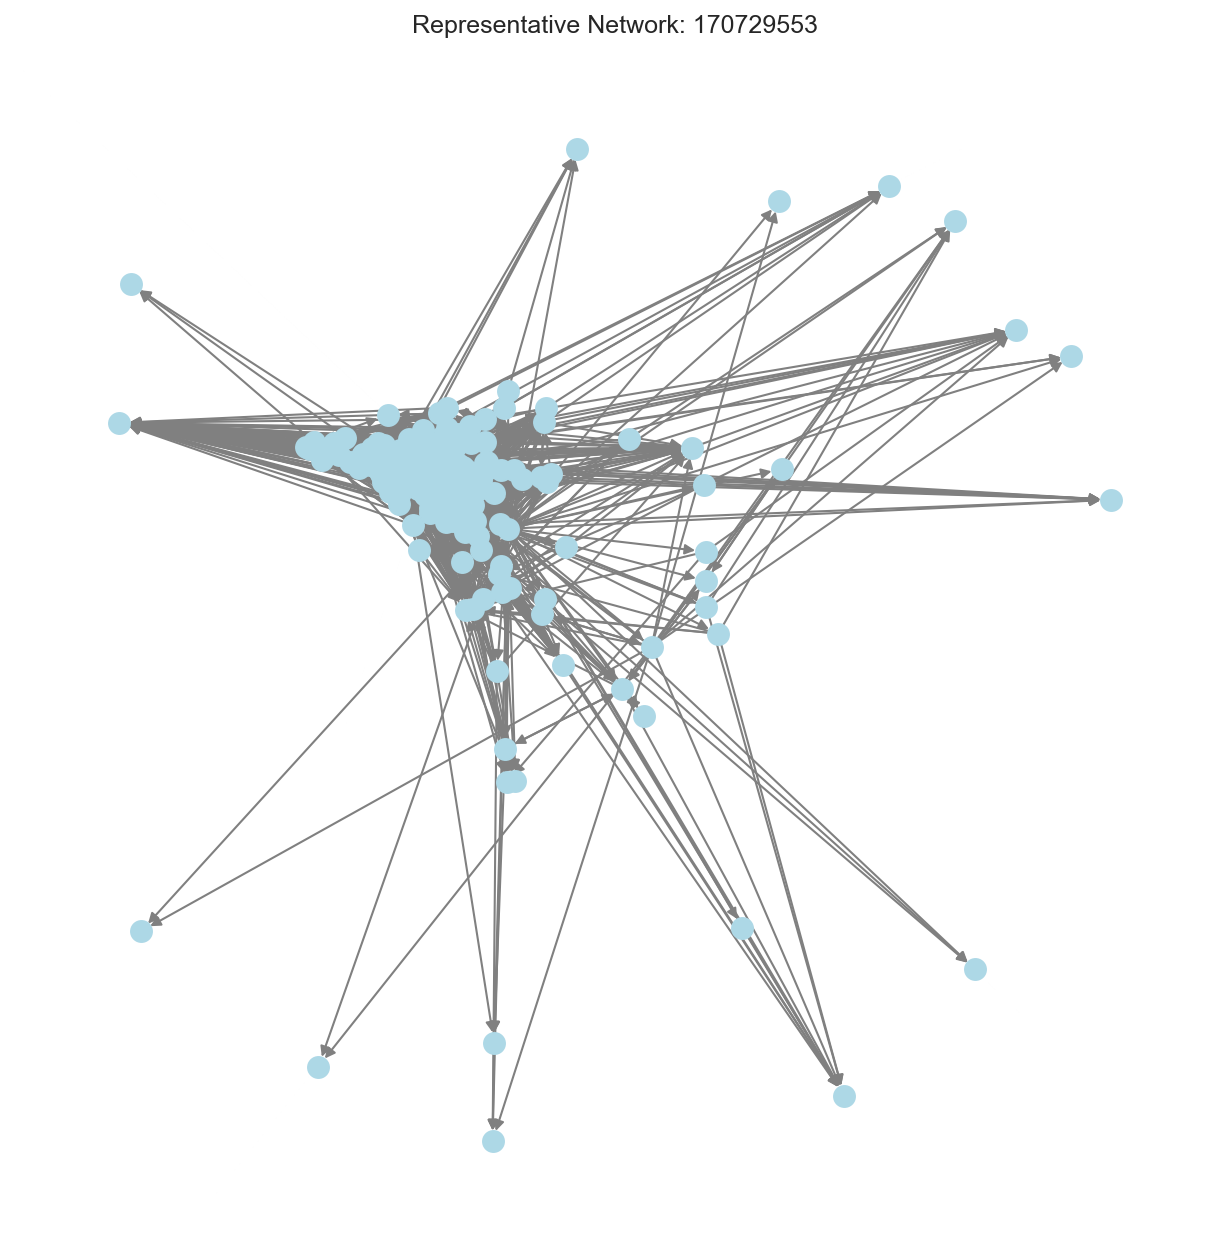

In [12]:
# display graph in notebook of representative network 
from IPython.display import display, Image

if representative_net in graphs:
    G = graphs[representative_net]
    out_path = summary_dir / f'{representative_net}_representative.png'
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=False, node_size=100, node_color='lightblue', edge_color='gray')
    plt.title(f"Representative Network: {representative_net}")
    plt.axis('off')
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.close()
    print('Graphe sauvegardé sous :', out_path)
    display(Image(filename=str(out_path)))

In [13]:
!pip install torch torchvision torchaudio
!pip install python-louvain



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


Preparing graph for GNN: 170729553
Prepared node features and labels saved to: twitter_ego/twitter/summary_tables/prepared_170729553_nodes.csv
Using device: cpu
Epoch 001  train_loss=0.5889  val_loss=0.6166  train_acc=0.682  val_acc=0.633
Epoch 050  train_loss=0.4637  val_loss=0.5016  train_acc=0.696  val_acc=0.673
Epoch 100  train_loss=0.4339  val_loss=0.4738  train_acc=0.770  val_acc=0.735
Epoch 150  train_loss=0.4097  val_loss=0.4553  train_acc=0.791  val_acc=0.735
Epoch 200  train_loss=0.3916  val_loss=0.4395  train_acc=0.797  val_acc=0.735

>>> Test accuracy: 0.784 <<<
Training history saved to: twitter_ego/twitter/summary_tables/170729553_training_history.csv
Training curves saved to: twitter_ego/twitter/summary_tables/170729553_training_curves.png


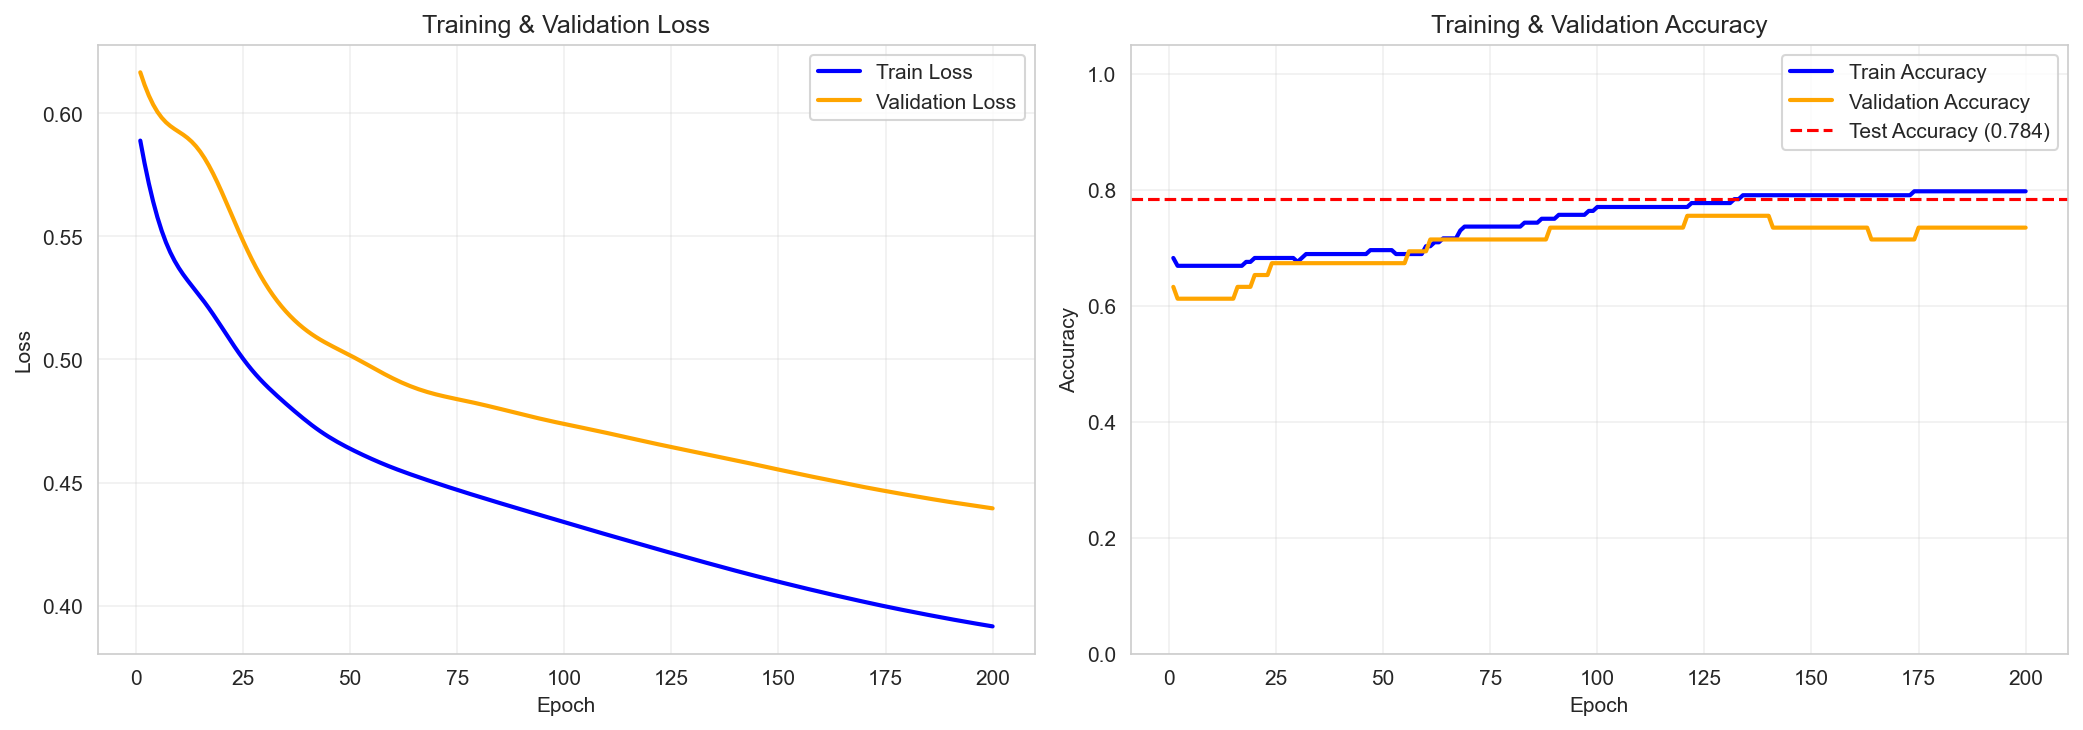

Saved node embeddings to: twitter_ego/twitter/summary_tables/170729553_node_embeddings.csv


In [14]:
# --- Prepare selected graph and run a small GCN (if torch available) ---
import numpy as np

if 'representative_net' not in globals() or representative_net is None:
    print('No representative network selected. Run the previous selection cell first.')
else:
    rep = representative_net
    print('Preparing graph for GNN:', rep)
    Gsel = graphs[rep].to_undirected()
    nodes = list(Gsel.nodes())
    n = len(nodes)
    if n == 0:
        print('Graph is empty.')
    else:
        idx = {node: i for i, node in enumerate(nodes)}
        A = nx.to_numpy_array(Gsel, nodelist=nodes)
        # Node features: degree and clustering (and ego feature if available)
        deg = np.array([Gsel.degree(n) for n in nodes], dtype=float)
        clust = np.array([nx.clustering(Gsel, n) for n in nodes], dtype=float)
        X = np.vstack([deg, clust]).T
        # Normalize features
        X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

        # Synthetic labels: bin degrees into 3 classes (low/med/high)
        try:
            import pandas as pd
            labels = pd.qcut(deg, q=3, labels=False, duplicates='drop').astype(int).values
            num_classes = int(labels.max() + 1)
        except Exception:
            labels = (deg > np.median(deg)).astype(int)
            num_classes = max(2, int(labels.max() + 1))

        # Save prepared data
        prep_df = pd.DataFrame(X, index=nodes, columns=['deg_z','clust_z'])
        prep_df['label'] = labels
        prep_df.to_csv(summary_dir / f'prepared_{rep}_nodes.csv')
        print(f'Prepared node features and labels saved to: {summary_dir}/prepared_{rep}_nodes.csv')

        # Try to run a small GCN using PyTorch (no torch -> show install instructions)
        try:
            import torch
            import torch.nn as nn
            import torch.nn.functional as F
            import torch.optim as optim

            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            print('Using device:', device)

            # Build normalized adjacency
            A_tilde = A + np.eye(n)
            D = np.diag(A_tilde.sum(axis=1))
            D_inv_sqrt = np.linalg.inv(np.sqrt(D))
            A_norm = D_inv_sqrt @ A_tilde @ D_inv_sqrt
            A_norm = torch.tensor(A_norm, dtype=torch.float32, device=device)
            X_t = torch.tensor(X, dtype=torch.float32, device=device)
            y = torch.tensor(labels, dtype=torch.long, device=device)

            # Simple train/val/test split
            rng = np.random.default_rng(42)
            perm = rng.permutation(n)
            n_train = max(1, int(0.6 * n))
            n_val = max(1, int(0.2 * n))
            idx_train = perm[:n_train]
            idx_val = perm[n_train:n_train + n_val]
            idx_test = perm[n_train + n_val:]

            class SimpleGCN(nn.Module):
                def __init__(self, in_feats, hid_feats, out_feats):
                    super().__init__()
                    self.w1 = nn.Parameter(torch.randn(in_feats, hid_feats) / np.sqrt(in_feats))
                    self.w2 = nn.Parameter(torch.randn(hid_feats, out_feats) / np.sqrt(hid_feats))

                def forward(self, X, A_norm):
                    H = A_norm @ (X @ self.w1)
                    H = F.relu(H)
                    Z = A_norm @ (H @ self.w2)
                    return Z

            model = SimpleGCN(in_feats=X.shape[1], hid_feats=16, out_feats=num_classes).to(device)
            opt = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            loss_fn = nn.CrossEntropyLoss()

            # Training history
            history = {
                'epoch': [],
                'train_loss': [],
                'val_loss': [],
                'train_acc': [],
                'val_acc': []
            }

            # Training loop
            best_val = 1e9
            best_state = None
            num_epochs = 200
            
            for epoch in range(1, num_epochs + 1):
                model.train()
                logits = model(X_t, A_norm)
                loss = loss_fn(logits[idx_train], y[idx_train])
                opt.zero_grad()
                loss.backward()
                opt.step()

                model.eval()
                with torch.no_grad():
                    logits = model(X_t, A_norm)
                    train_loss = loss_fn(logits[idx_train], y[idx_train]).item()
                    val_loss = loss_fn(logits[idx_val], y[idx_val]).item() if len(idx_val)>0 else 0.0
                    pred = logits.argmax(dim=1)
                    train_acc = (pred[idx_train] == y[idx_train]).float().mean().item()
                    val_acc = (pred[idx_val] == y[idx_val]).float().mean().item() if len(idx_val)>0 else 0.0
                
                # Store history
                history['epoch'].append(epoch)
                history['train_loss'].append(train_loss)
                history['val_loss'].append(val_loss)
                history['train_acc'].append(train_acc)
                history['val_acc'].append(val_acc)
                
                if epoch % 50 == 0 or epoch == 1:
                    print(f'Epoch {epoch:03d}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  train_acc={train_acc:.3f}  val_acc={val_acc:.3f}')
                if val_loss < best_val:
                    best_val = val_loss
                    best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

            # Evaluate on test set
            if best_state is not None:
                model.load_state_dict(best_state)
            model.eval()
            with torch.no_grad():
                logits = model(X_t, A_norm)
                pred = logits.argmax(dim=1)
                test_acc = (pred[idx_test] == y[idx_test]).float().mean().item() if len(idx_test)>0 else 0.0
            print(f'\n>>> Test accuracy: {test_acc:.3f} <<<')

            # Save training history
            history_df = pd.DataFrame(history)
            history_df.to_csv(summary_dir / f'{rep}_training_history.csv', index=False)
            print(f'Training history saved to: {summary_dir}/{rep}_training_history.csv')

            # Plot training curves
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Loss curves
            axes[0].plot(history['epoch'], history['train_loss'], label='Train Loss', color='blue', linewidth=2)
            axes[0].plot(history['epoch'], history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].set_title('Training & Validation Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Accuracy curves
            axes[1].plot(history['epoch'], history['train_acc'], label='Train Accuracy', color='blue', linewidth=2)
            axes[1].plot(history['epoch'], history['val_acc'], label='Validation Accuracy', color='orange', linewidth=2)
            axes[1].axhline(y=test_acc, color='red', linestyle='--', label=f'Test Accuracy ({test_acc:.3f})')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].set_title('Training & Validation Accuracy')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            axes[1].set_ylim([0, 1.05])
            
            plt.tight_layout()
            out_path = summary_dir / f'{rep}_training_curves.png'
            plt.savefig(out_path, dpi=150, bbox_inches='tight')
            plt.close()
            print(f'Training curves saved to: {out_path}')
            
            # Display the plot
            from IPython.display import display, Image
            display(Image(filename=str(out_path)))

            # Save node embeddings (hidden layer activations)
            with torch.no_grad():
                H = F.relu(A_norm @ (X_t @ model.w1))
                emb = H.cpu().numpy()
            emb_df = pd.DataFrame(emb, index=nodes)
            emb_df.to_csv(summary_dir / f'{rep}_node_embeddings.csv')
            print('Saved node embeddings to:', summary_dir / f'{rep}_node_embeddings.csv')

        except Exception as e:
            print('PyTorch not available or error during training:', e)
            print('To run the GCN, install PyTorch (and optional GPU support). Example:')
            print('\n  pip install torch torchvision torchaudio\n')
            print('Then re-run this cell.')

## 9. Optional: Correlation Heatmap (single plot)

Produce one heatmap image saved to summary_dir if desired.

In [15]:
metrics_cols = [c for c in ['num_nodes','num_edges','density','avg_degree','avg_clustering','transitivity','mean_in_degree','mean_out_degree'] if c in comprehensive_df.columns]
if len(metrics_cols) >= 2:
    corr = comprehensive_df[metrics_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=0.8, cbar_kws={'shrink':0.8})
    plt.title('Correlation Matrix of Network Metrics')
    plt.tight_layout()
    plt.savefig(summary_dir / 'correlation_heatmap.png', dpi=150, bbox_inches='tight')
    plt.close()
    print('Saved correlation_heatmap.png')
else:
    print('Not enough metrics for heatmap')

Saved correlation_heatmap.png


Graphe sauvegardé sous : twitter_ego/twitter/summary_tables/170729553_graph.png


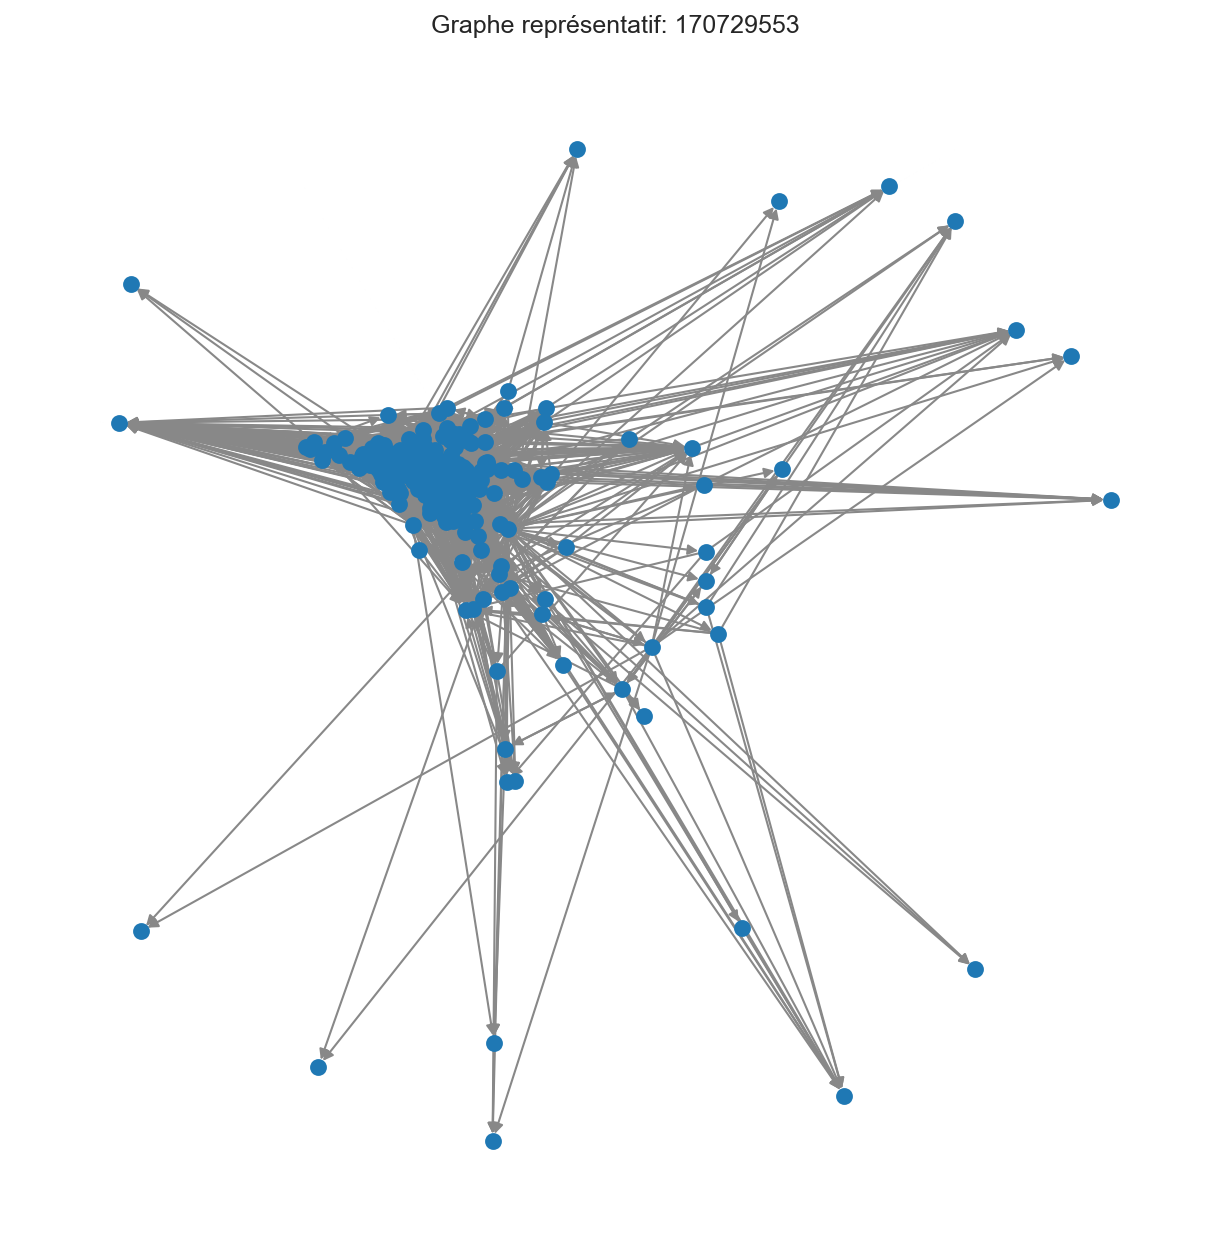

In [16]:
# Save and display the representative graph image
from IPython.display import display, Image
rep = globals().get('representative_net', None)
if rep is None:
    print('Aucun graphe représentatif sélectionné. Exécutez la cellule de sélection dabord.')
else:
    if 'graphs' not in globals() or rep not in graphs:
        print(f'Graphe {rep} introuvable dans la variable graphs.')
    else:
        Grep = graphs[rep]
        out_path = summary_dir / f'{rep}_graph.png'
        plt.figure(figsize=(8,8))
        pos = nx.spring_layout(Grep, seed=42)
        nx.draw(Grep, pos=pos, node_size=50, with_labels=False, edge_color='#888888')
        plt.title(f'Graphe représentatif: {rep}')
        plt.tight_layout()
        plt.savefig(out_path, dpi=150, bbox_inches='tight')
        plt.close()
        print('Graphe sauvegardé sous :', out_path)
        try:
            display(Image(filename=str(out_path)))
        except Exception:
            print('Impossible dafficher limage dans cet environnement; le fichier est sauvegardé.')

Graphe sauvegardé sous : betweenness.png


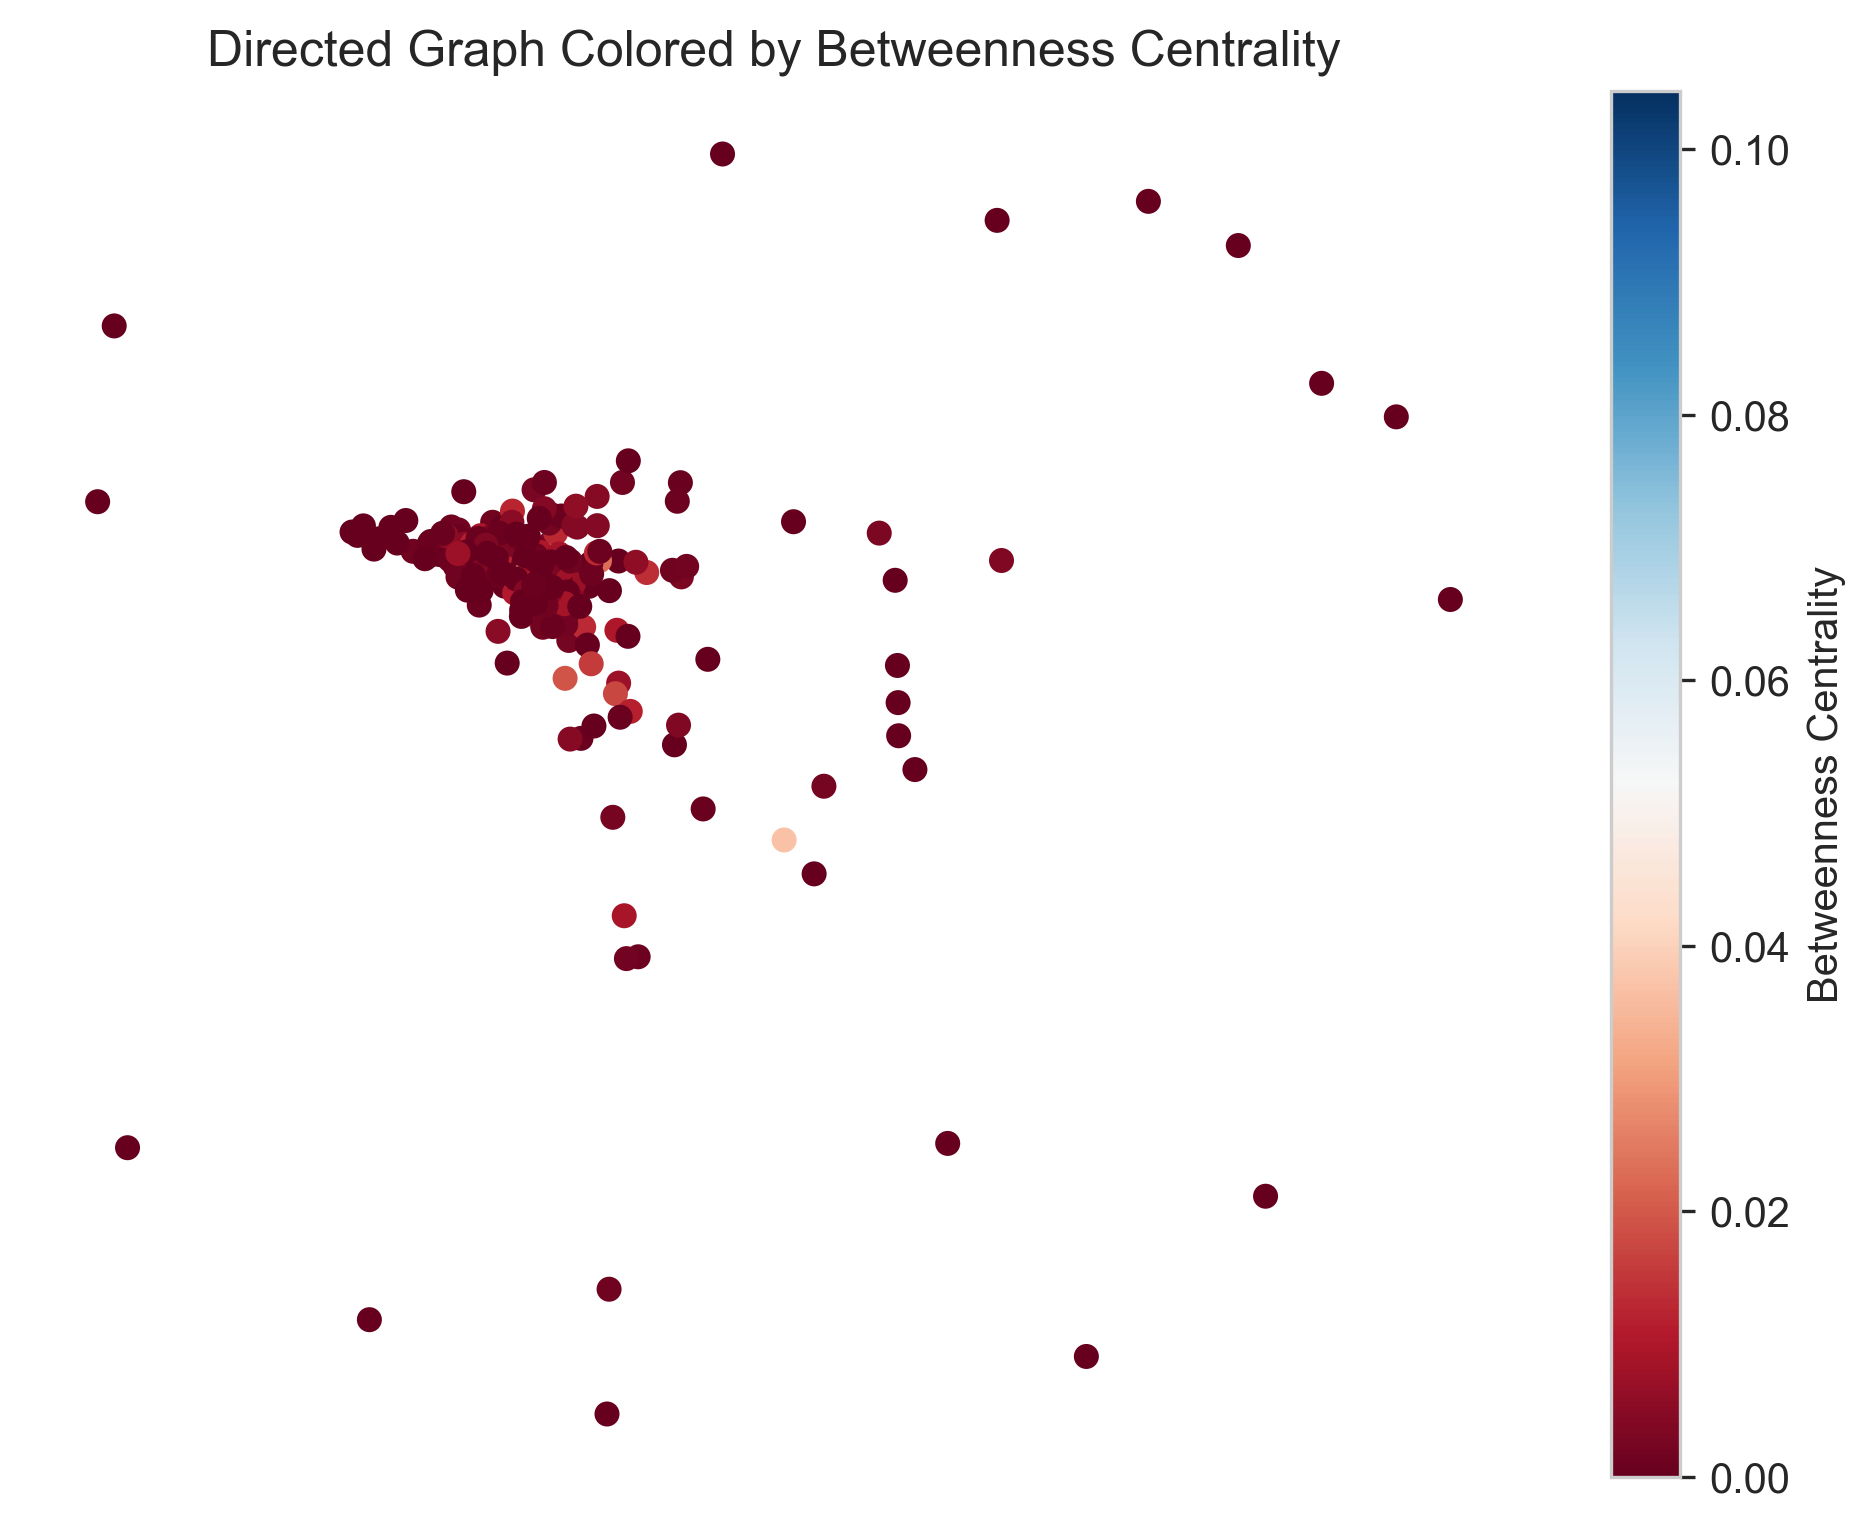

In [17]:
from IPython.display import display, Image

# 1. Compute betweenness centrality (directed)

rep = globals().get('representative_net', None)
G = graphs[rep]
out_path = 'betweenness.png'

betweenness = nx.betweenness_centrality(G, normalized=True)

# 2. Prepare node colors (least = red, greatest = blue)
values = list(betweenness.values())

# Layout for visualization
pos = nx.spring_layout(G, seed=42)

# 3. Draw graph
plt.figure(figsize=(8, 6))

nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=25,
    node_color=values,
    cmap=plt.cm.RdBu,   # red → blue
    vmin=min(values),
    vmax=max(values)
)

# Colorbar
cbar = plt.colorbar(nodes)
cbar.set_label("Betweenness Centrality")

plt.title("Directed Graph Colored by Betweenness Centrality")
plt.axis("off")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.close()
print('Graphe sauvegardé sous :', out_path)

display(Image(filename=str(out_path)))

## Centralités complètes

Calcul de toutes les centralités requises : Degree, Eigenvector, Closeness, Betweenness, PageRank.

In [18]:
# ============================================================================
# CALCUL DE TOUTES LES CENTRALITÉS
# ============================================================================
from IPython.display import display, Image
import time

rep = globals().get('representative_net', None)
if rep is None:
    print("Pas de graphe sélectionné.")
else:
    G = graphs[rep]
    G_undirected = G.to_undirected()
    
    print(f"Calcul des centralités pour le graphe {rep}...")
    print(f"Nœuds: {G.number_of_nodes()}, Arêtes: {G.number_of_edges()}")
    print("="*60)
    
    # 1. Degree Centrality
    print("1/5 Degree Centrality...")
    degree_centrality = nx.degree_centrality(G)
    in_degree_centrality = nx.in_degree_centrality(G)
    out_degree_centrality = nx.out_degree_centrality(G)
    
    # 2. Eigenvector Centrality (sur graphe non-dirigé pour convergence)
    print("2/5 Eigenvector Centrality...")
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G_undirected, max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        print("   ⚠️ Eigenvector n'a pas convergé, utilisation de numpy...")
        eigenvector_centrality = nx.eigenvector_centrality_numpy(G_undirected)
    
    # 3. Closeness Centrality
    print("3/5 Closeness Centrality...")
    closeness_centrality = nx.closeness_centrality(G)
    
    # 4. Betweenness Centrality
    print("4/5 Betweenness Centrality...")
    betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
    
    # 5. PageRank
    print("5/5 PageRank...")
    pagerank = nx.pagerank(G, alpha=0.85)
    
    print("="*60)
    print("✅ Toutes les centralités calculées!")
    
    # Créer un DataFrame récapitulatif
    nodes_list = list(G.nodes())
    centrality_df = pd.DataFrame({
        'node': nodes_list,
        'degree': [degree_centrality[n] for n in nodes_list],
        'in_degree': [in_degree_centrality[n] for n in nodes_list],
        'out_degree': [out_degree_centrality[n] for n in nodes_list],
        'eigenvector': [eigenvector_centrality.get(n, 0) for n in nodes_list],
        'closeness': [closeness_centrality[n] for n in nodes_list],
        'betweenness': [betweenness_centrality[n] for n in nodes_list],
        'pagerank': [pagerank[n] for n in nodes_list],
    })
    centrality_df = centrality_df.set_index('node')
    
    # Sauvegarder
    centrality_df.to_csv(summary_dir / f'{rep}_all_centralities.csv')
    print(f"\nSauvegardé: {summary_dir}/{rep}_all_centralities.csv")
    
    # Afficher les top 10 pour chaque centralité
    print("\n" + "="*60)
    print("TOP 10 NŒUDS PAR CENTRALITÉ")
    print("="*60)
    
    for col in ['degree', 'eigenvector', 'closeness', 'betweenness', 'pagerank']:
        top10 = centrality_df[col].nlargest(10)
        print(f"\n🔹 {col.upper()}:")
        for i, (node, val) in enumerate(top10.items(), 1):
            print(f"   {i:2d}. {node}: {val:.4f}")

Calcul des centralités pour le graphe 170729553...
Nœuds: 248, Arêtes: 8237
1/5 Degree Centrality...
2/5 Eigenvector Centrality...
3/5 Closeness Centrality...
4/5 Betweenness Centrality...
5/5 PageRank...
✅ Toutes les centralités calculées!

Sauvegardé: twitter_ego/twitter/summary_tables/170729553_all_centralities.csv

TOP 10 NŒUDS PAR CENTRALITÉ

🔹 DEGREE:
    1. 170729553: 1.0000
    2. 3359851: 0.8583
    3. 187744415: 0.8583
    4. 94480069: 0.8178
    5. 16464746: 0.7976
    6. 22784458: 0.7854
    7. 35722372: 0.7530
    8. 18776017: 0.7247
    9. 131601987: 0.7126
   10. 141021153: 0.7085

🔹 EIGENVECTOR:
    1. 170729553: 0.1755
    2. 3359851: 0.1392
    3. 34068984: 0.1371
    4. 22784458: 0.1313
    5. 16464746: 0.1308
    6. 187744415: 0.1301
    7. 94480069: 0.1282
    8. 126444583: 0.1266
    9. 131601987: 0.1266
   10. 18776017: 0.1252

🔹 CLOSENESS:
    1. 3359851: 0.6262
    2. 16464746: 0.6208
    3. 34068984: 0.6190
    4. 22784458: 0.5871
    5. 187744415: 0.5855
    

STATISTIQUES DESCRIPTIVES DES CENTRALITÉS


,degree,in_degree,out_degree,eigenvector,closeness,betweenness,pagerank
count,248.0000,248.0000,248.0000,248.0000,248.0000,248.0000,248.0000
mean,0.2689,0.1345,0.1345,0.0517,0.4016,0.0045,0.0040
std,0.2056,0.1229,0.1170,0.0369,0.1265,0.0094,0.0036
min,0.0081,0.0000,0.0000,0.0025,0.0000,0.0000,0.0007
25%,0.0891,0.0405,0.0324,0.0195,0.3738,0.0002,0.0015
50%,0.2510,0.0911,0.1215,0.0474,0.4299,0.0014,0.0029
75%,0.3806,0.1994,0.1994,0.0771,0.4709,0.0047,0.0052
max,1.0000,0.5628,1.0000,0.1755,0.6262,0.1044,0.0228



CORRÉLATION ENTRE CENTRALITÉS


,degree,eigenvector,closeness,betweenness,pagerank
degree,1.000,0.966,0.629,0.522,0.692
eigenvector,0.966,1.000,0.639,0.412,0.659
closeness,0.629,0.639,1.000,0.312,0.622
betweenness,0.522,0.412,0.312,1.000,0.482
pagerank,0.692,0.659,0.622,0.482,1.000



Sauvegardé: twitter_ego/twitter/summary_tables/170729553_centrality_correlation.png


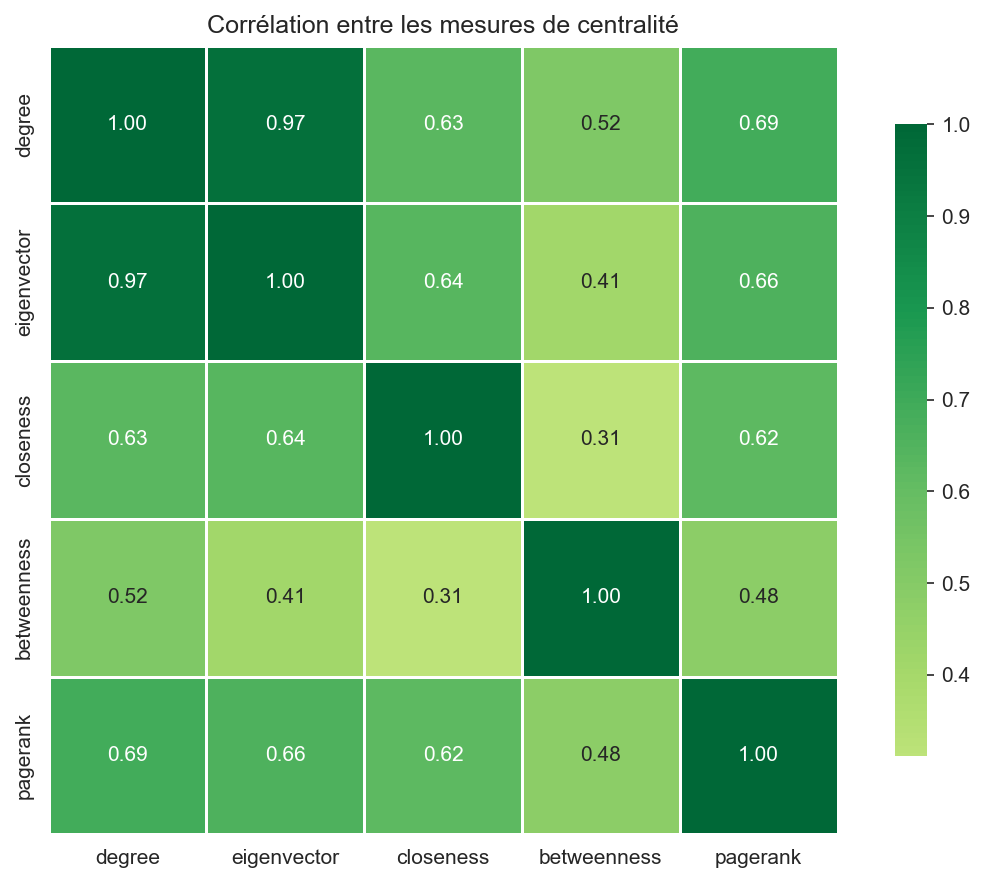

In [19]:
# ============================================================================
# TABLEAU COMPARATIF DES CENTRALITÉS
# ============================================================================

# Statistiques descriptives
print("STATISTIQUES DESCRIPTIVES DES CENTRALITÉS")
print("="*60)
display(centrality_df.describe().round(4))

# Matrice de corrélation entre centralités
print("\n" + "="*60)
print("CORRÉLATION ENTRE CENTRALITÉS")
print("="*60)
corr_centralities = centrality_df[['degree', 'eigenvector', 'closeness', 'betweenness', 'pagerank']].corr()
display(corr_centralities.round(3))

# Heatmap des corrélations
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_centralities, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8}, ax=ax)
ax.set_title('Corrélation entre les mesures de centralité')
plt.tight_layout()
out_path = summary_dir / f'{rep}_centrality_correlation.png'
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.close()
print(f"\nSauvegardé: {out_path}")
display(Image(filename=str(out_path)))

# Sauvegarder la matrice de corrélation
corr_centralities.to_csv(summary_dir / f'{rep}_centrality_correlation.csv')

Sauvegardé: twitter_ego/twitter/summary_tables/170729553_centralities_comparison.png


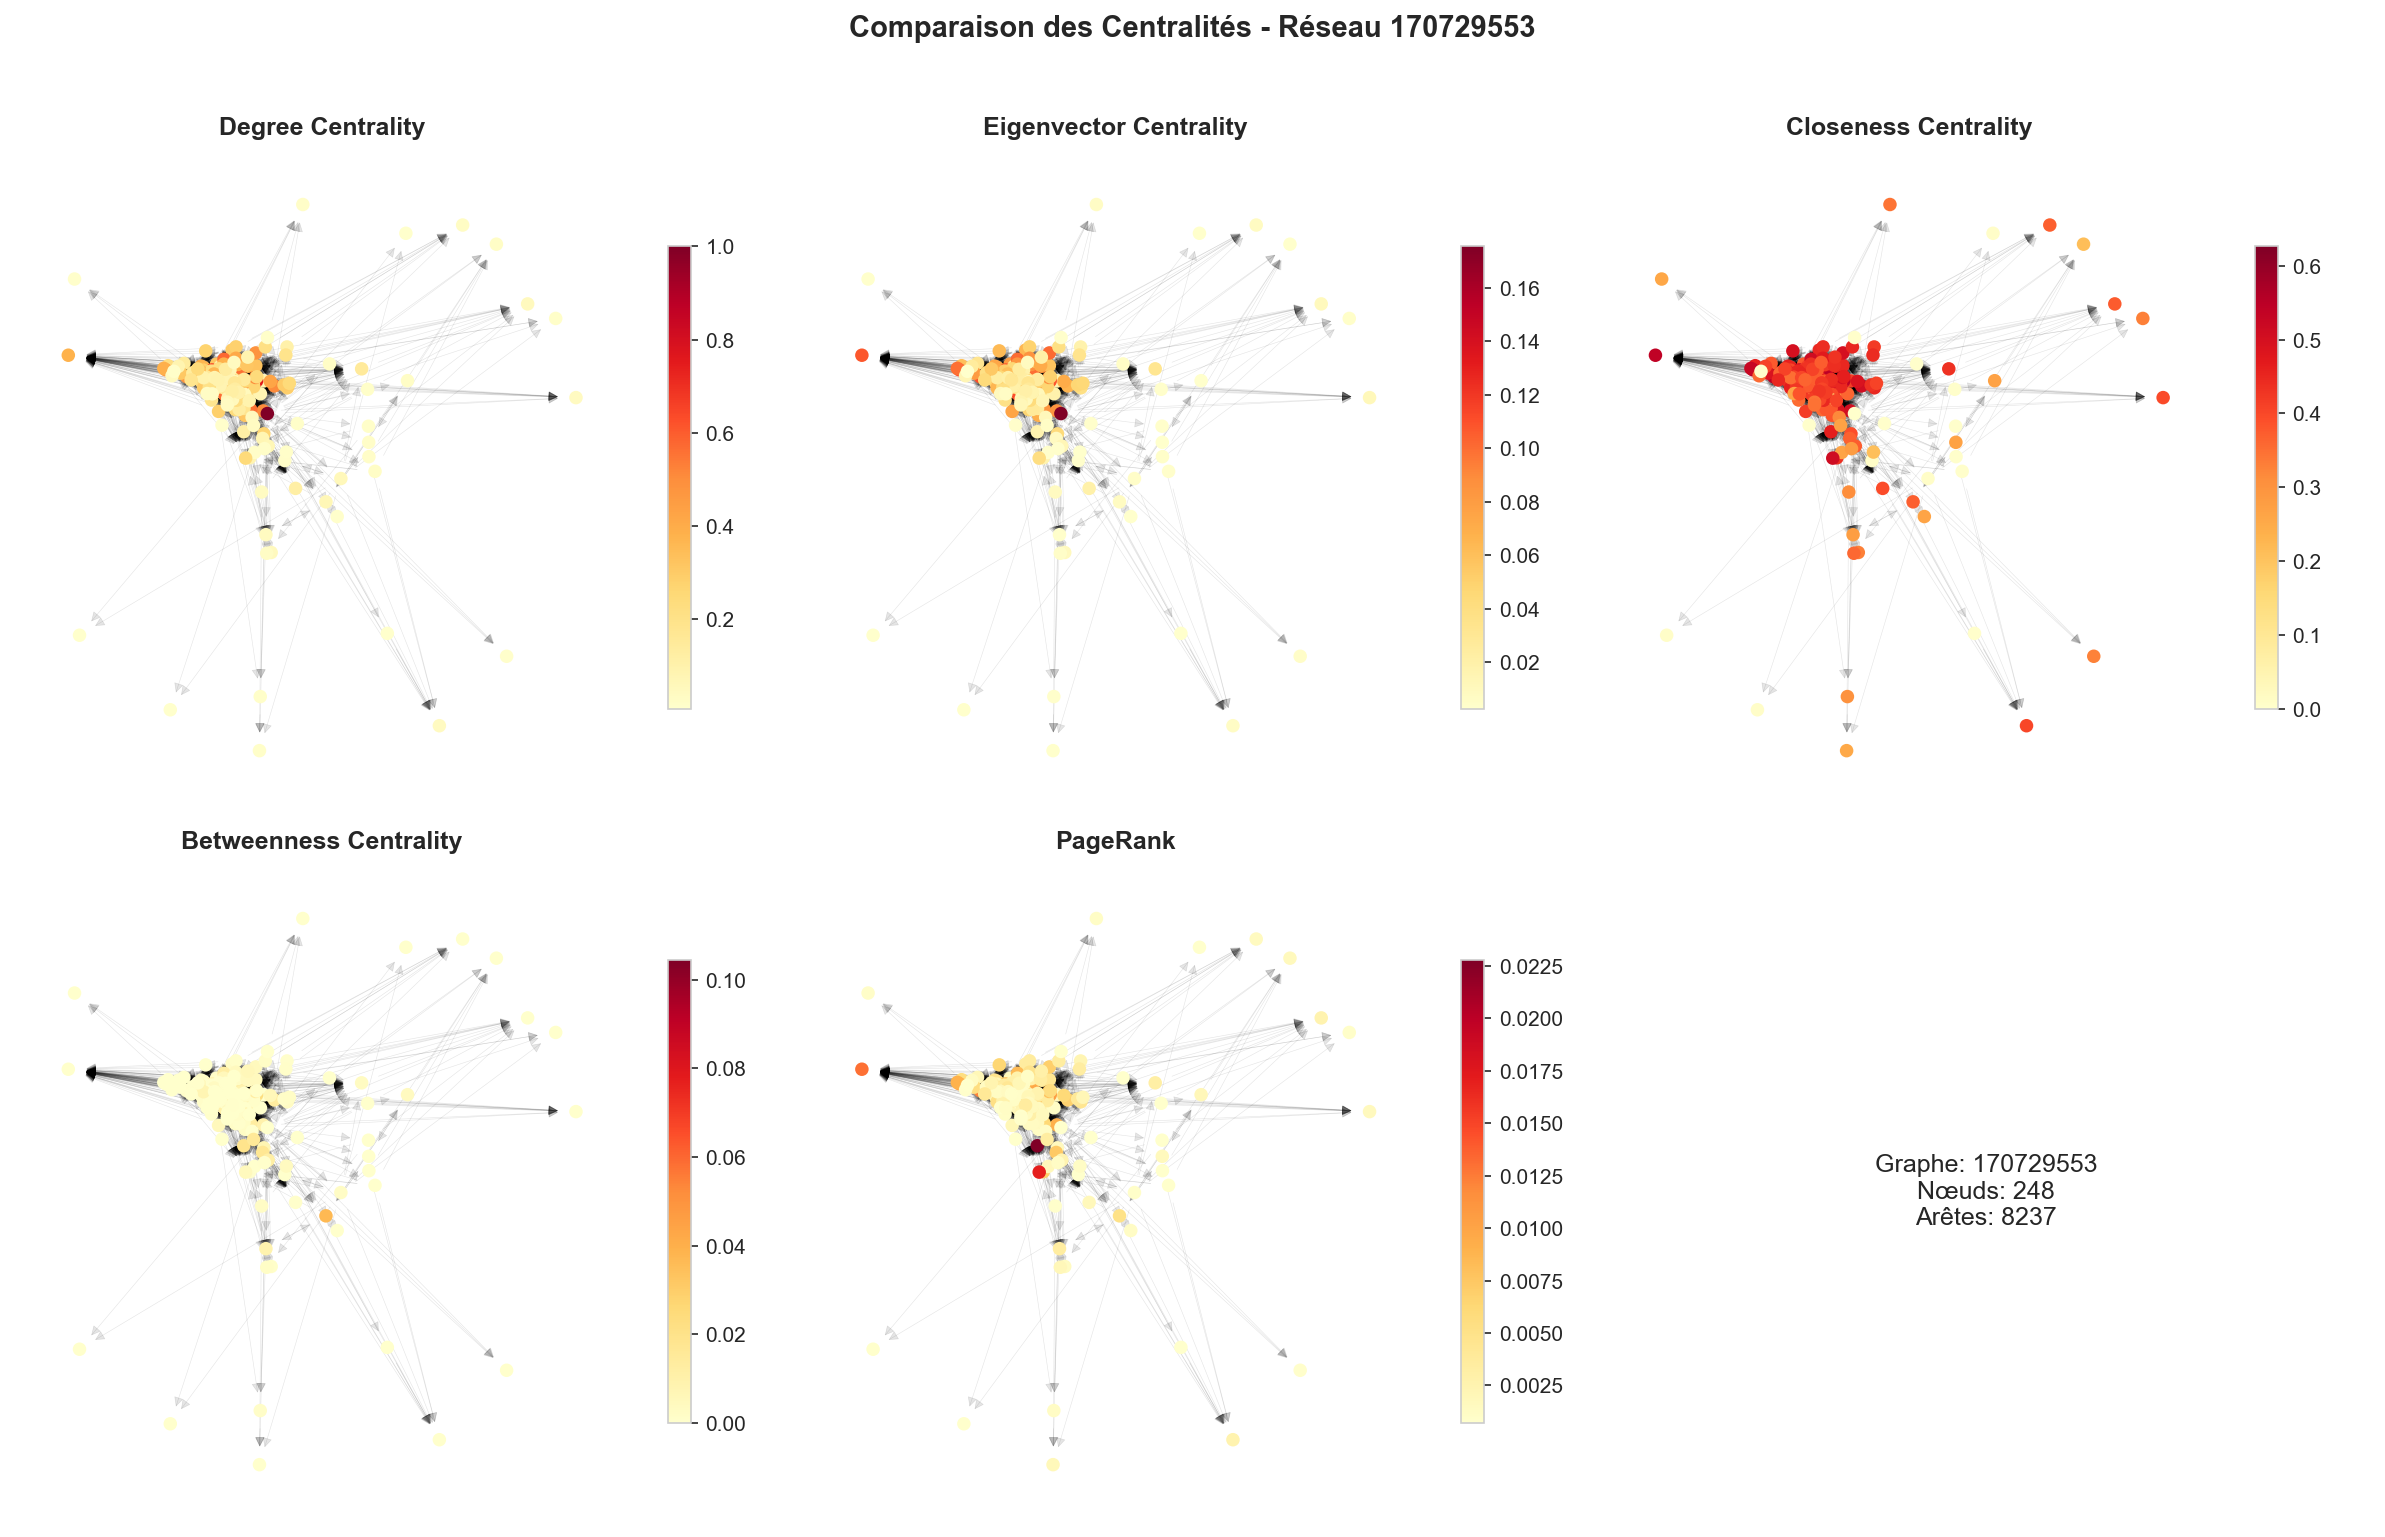

In [20]:
# ============================================================================
# VISUALISATION COMPARATIVE DES CENTRALITÉS
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
pos = nx.spring_layout(G, seed=42)

centralities = [
    ('degree', degree_centrality, 'Degree Centrality'),
    ('eigenvector', {n: eigenvector_centrality.get(n, 0) for n in G.nodes()}, 'Eigenvector Centrality'),
    ('closeness', closeness_centrality, 'Closeness Centrality'),
    ('betweenness', betweenness_centrality, 'Betweenness Centrality'),
    ('pagerank', pagerank, 'PageRank'),
]

for idx, (name, cent_dict, title) in enumerate(centralities):
    ax = axes[idx // 3, idx % 3]
    values = [cent_dict[n] for n in G.nodes()]
    
    nodes = nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=30,
        node_color=values,
        cmap=plt.cm.YlOrRd,
        vmin=min(values),
        vmax=max(values)
    )
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.1, width=0.3)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')
    plt.colorbar(nodes, ax=ax, shrink=0.7)

# Cacher le 6ème subplot (vide)
axes[1, 2].axis('off')
axes[1, 2].text(0.5, 0.5, f'Graphe: {rep}\nNœuds: {G.number_of_nodes()}\nArêtes: {G.number_of_edges()}',
                ha='center', va='center', fontsize=12, transform=axes[1, 2].transAxes)

plt.suptitle(f'Comparaison des Centralités - Réseau {rep}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
out_path = summary_dir / f'{rep}_centralities_comparison.png'
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.close()
print(f"Sauvegardé: {out_path}")
display(Image(filename=str(out_path)))

### Interprétation des centralités

| Centralité | Signification | Nœuds importants selon cette mesure |
|------------|---------------|-------------------------------------|
| **Degree** | Nombre de connexions directes | Nœuds les plus connectés (hubs) |
| **Eigenvector** | Connexion à des nœuds eux-mêmes bien connectés | Nœuds influents par association |
| **Closeness** | Proximité moyenne à tous les autres nœuds | Nœuds centraux pour la diffusion rapide |
| **Betweenness** | Fréquence sur les plus courts chemins | Nœuds "ponts" entre communautés |
| **PageRank** | Importance récursive (liens entrants pondérés) | Nœuds vers lesquels pointent des nœuds importants |

**Observations attendues :**
- Forte corrélation Degree ↔ Eigenvector (les hubs sont souvent connectés entre eux)
- Betweenness peut identifier des nœuds moins connectés mais structurellement critiques
- PageRank et Eigenvector capturent l'influence indirecte

Graphe sauvegardé sous : pagerank.png


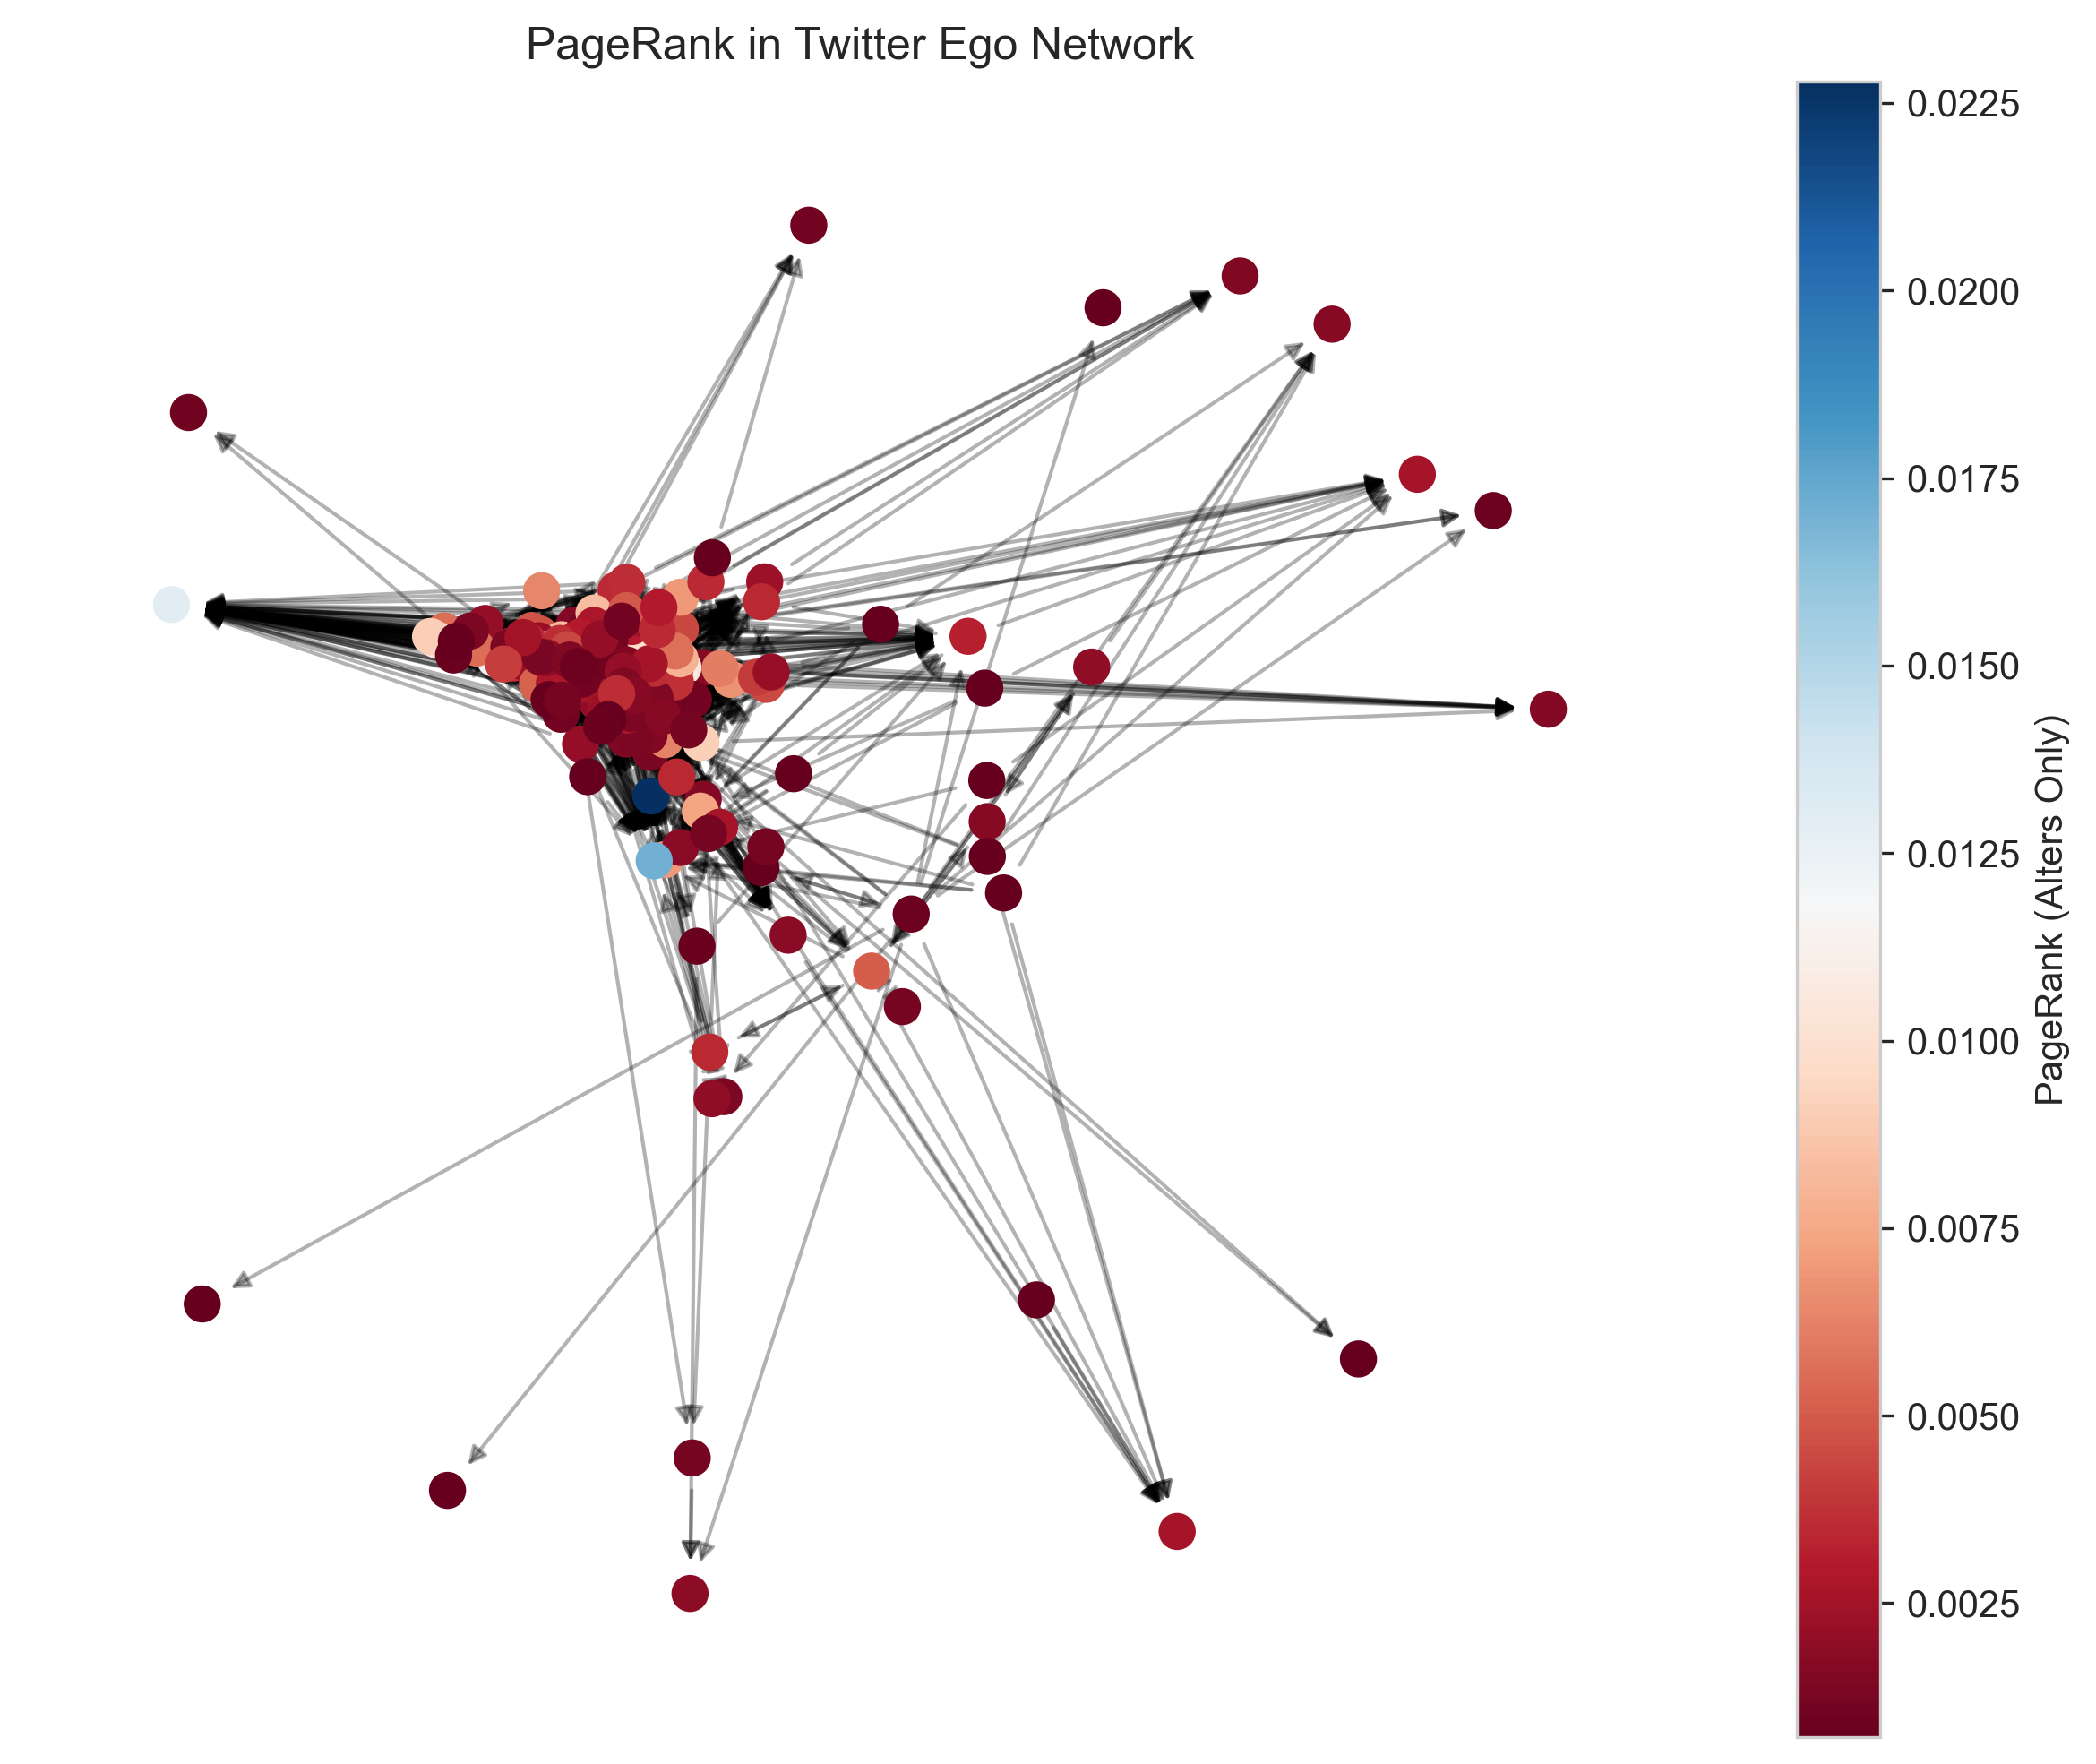

In [21]:
#page rank

import matplotlib.pyplot as plt

#remove ego from graph before doing page rank
ego = rep

G_no_ego = G.copy()
G_no_ego.remove_node(ego)

pagerank_alters = nx.pagerank(G_no_ego, alpha=0.85)

out_path = 'pagerank.png'


values = list(pagerank_alters.values())

pos = nx.spring_layout(G_no_ego, seed=42)

plt.figure(figsize=(10, 8))
nodes = nx.draw_networkx_nodes(
    G_no_ego,
    pos,
    node_color=values,
    cmap=plt.cm.RdBu,
    node_size=80
)

nx.draw_networkx_edges(G_no_ego, pos, alpha=0.3)
plt.colorbar(nodes, label="PageRank (Alters Only)")
plt.title("PageRank in Twitter Ego Network")
plt.axis("off")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.close()
print('Graphe sauvegardé sous :', out_path)

display(Image(filename=str(out_path)))


Graphe sauvegardé sous : community.png


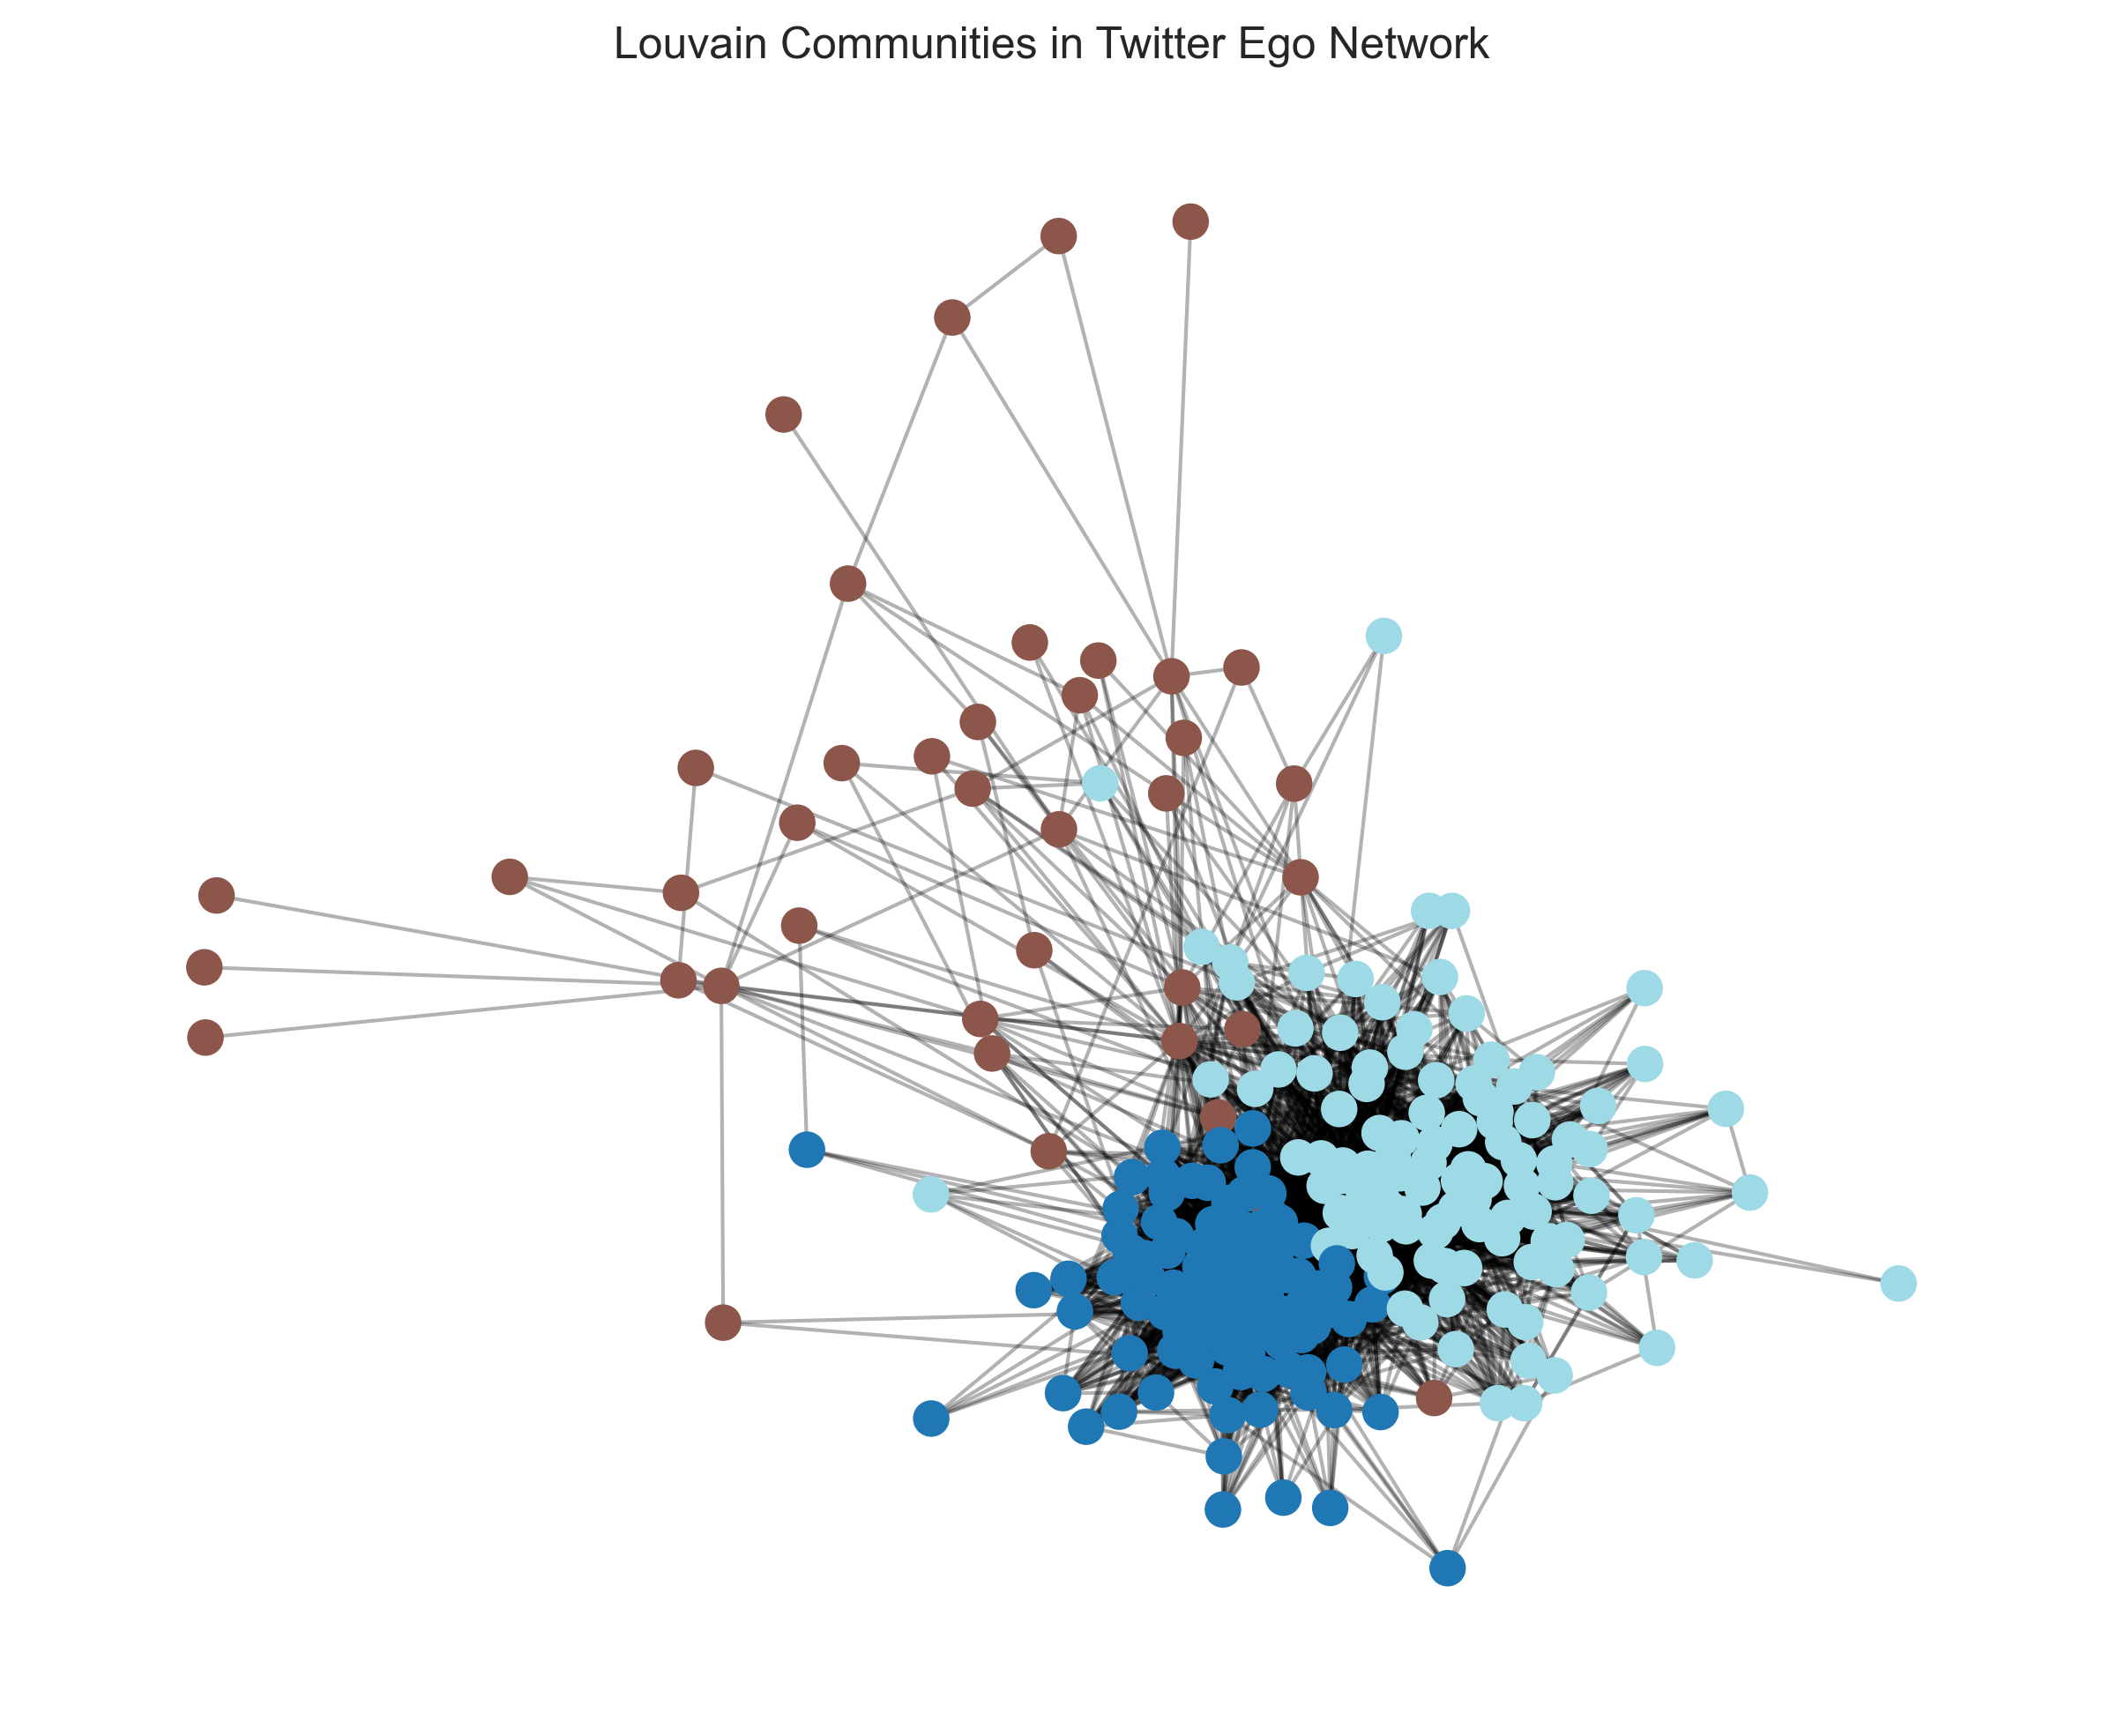

In [22]:
#louvain community detection
#only on undirected graph
import community.community_louvain as community_louvain

G_undirected = G_no_ego.to_undirected()
partition = community_louvain.best_partition(G_undirected)

# Get community labels
communities = list(partition.values())

pos = nx.spring_layout(G_undirected, seed=42)

plt.figure(figsize=(10, 8))

nodes = nx.draw_networkx_nodes(
    G_undirected,
    pos,
    node_color=communities,
    cmap=plt.cm.tab20,   # categorical colormap
    node_size=80
)

nx.draw_networkx_edges(G_undirected, pos, alpha=0.3)

out_path = 'community.png'

plt.title("Louvain Communities in Twitter Ego Network")
plt.axis("off")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.close()
print('Graphe sauvegardé sous :', out_path)

display(Image(filename=str(out_path)))


## Détection de communautés : Girvan-Newman

Algorithme divisif : supprime itérativement les arêtes à haute betweenness pour révéler la structure communautaire.

In [ ]:
# ============================================================================
# GIRVAN-NEWMAN COMMUNITY DETECTION
# ============================================================================
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community.quality import modularity
import itertools

print("Détection de communautés avec Girvan-Newman...")
print("⚠️ Cet algorithme peut prendre quelques minutes sur un graphe de ~250 nœuds")
print("="*60)

# Utiliser le graphe non dirigé sans l'ego
G_gn = G_undirected.copy()

# Girvan-Newman retourne un générateur de partitions
# On va chercher la partition qui maximise la modularité
gn_generator = girvan_newman(G_gn)

# Limiter à un nombre raisonnable d'itérations pour éviter trop de calcul
# On teste jusqu'à 15 communautés max
max_communities = min(15, G_gn.number_of_nodes() // 5)
best_modularity = -1
best_partition_gn = None
best_k = 0

print(f"Recherche de la meilleure partition (max {max_communities} communautés)...")

for i, communities_tuple in enumerate(itertools.islice(gn_generator, max_communities - 1)):
    # communities_tuple est un tuple de frozensets
    communities_list = [set(c) for c in communities_tuple]
    k = len(communities_list)
    
    # Calculer la modularité
    mod = modularity(G_gn, communities_list)
    
    if mod > best_modularity:
        best_modularity = mod
        best_partition_gn = communities_list
        best_k = k
    
    if (i + 1) % 3 == 0:
        print(f"  Itération {i+1}: {k} communautés, modularité = {mod:.4f}")

print("="*60)
print(f"✅ Meilleure partition trouvée: {best_k} communautés")
print(f"   Modularité Girvan-Newman: {best_modularity:.4f}")

# Créer un dictionnaire node -> community pour comparaison avec Louvain
partition_gn = {}
for idx, community in enumerate(best_partition_gn):
    for node in community:
        partition_gn[node] = idx

# Statistiques des communautés
community_sizes_gn = [len(c) for c in best_partition_gn]
print(f"   Tailles des communautés: {sorted(community_sizes_gn, reverse=True)}")

# Sauvegarder
gn_df = pd.DataFrame({'node': list(partition_gn.keys()), 'community_gn': list(partition_gn.values())})
gn_df.to_csv(summary_dir / f'{rep}_girvan_newman_communities.csv', index=False)
print(f"\nSauvegardé: {summary_dir}/{rep}_girvan_newman_communities.csv")

In [ ]:
# ============================================================================
# VISUALISATION GIRVAN-NEWMAN
# ============================================================================

communities_gn = [partition_gn[n] for n in G_undirected.nodes()]

plt.figure(figsize=(10, 8))
nodes = nx.draw_networkx_nodes(
    G_undirected,
    pos,
    node_color=communities_gn,
    cmap=plt.cm.tab20,
    node_size=80
)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.3)

out_path = summary_dir / f'{rep}_girvan_newman.png'
plt.title(f"Girvan-Newman Communities ({best_k} communautés, Q={best_modularity:.3f})")
plt.axis("off")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Sauvegardé: {out_path}")
display(Image(filename=str(out_path)))

In [ ]:
# ============================================================================
# COMPARAISON LOUVAIN vs GIRVAN-NEWMAN
# ============================================================================

# Calculer la modularité de Louvain
louvain_communities = {}
for node, comm in partition.items():
    if comm not in louvain_communities:
        louvain_communities[comm] = set()
    louvain_communities[comm].add(node)
louvain_communities_list = list(louvain_communities.values())
modularity_louvain = modularity(G_undirected, louvain_communities_list)

print("="*60)
print("COMPARAISON DES ALGORITHMES DE DÉTECTION DE COMMUNAUTÉS")
print("="*60)

comparison_data = {
    'Algorithme': ['Louvain', 'Girvan-Newman'],
    'Type': ['Agglomératif', 'Divisif'],
    'Nb communautés': [len(set(partition.values())), best_k],
    'Modularité': [modularity_louvain, best_modularity],
    'Complexité': ['O(n log n)', 'O(m² n)'],
}
comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Sauvegarder
comparison_df.to_csv(summary_dir / f'{rep}_community_comparison.csv', index=False)

# Visualisation côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Louvain
ax1 = axes[0]
communities_louvain = [partition[n] for n in G_undirected.nodes()]
nx.draw_networkx_nodes(G_undirected, pos, ax=ax1, node_color=communities_louvain, 
                       cmap=plt.cm.tab20, node_size=60)
nx.draw_networkx_edges(G_undirected, pos, ax=ax1, alpha=0.2)
ax1.set_title(f'Louvain\n{len(set(partition.values()))} communautés, Q={modularity_louvain:.3f}', 
              fontsize=12, fontweight='bold')
ax1.axis('off')

# Girvan-Newman
ax2 = axes[1]
nx.draw_networkx_nodes(G_undirected, pos, ax=ax2, node_color=communities_gn, 
                       cmap=plt.cm.tab20, node_size=60)
nx.draw_networkx_edges(G_undirected, pos, ax=ax2, alpha=0.2)
ax2.set_title(f'Girvan-Newman\n{best_k} communautés, Q={best_modularity:.3f}', 
              fontsize=12, fontweight='bold')
ax2.axis('off')

plt.suptitle(f'Comparaison des méthodes de détection de communautés - Réseau {rep}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
out_path = summary_dir / f'{rep}_community_comparison.png'
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.close()
print(f"\nSauvegardé: {out_path}")
display(Image(filename=str(out_path)))

### Interprétation : Louvain vs Girvan-Newman

| Aspect | Louvain | Girvan-Newman |
|--------|---------|---------------|
| **Approche** | Agglomérative (fusion bottom-up) | Divisive (suppression d'arêtes top-down) |
| **Optimisation** | Maximise la modularité localement | Supprime les arêtes à haute betweenness |
| **Vitesse** | Rapide O(n log n) | Lent O(m² n) |
| **Résultat** | Nombre de communautés automatique | Contrôle du nombre via itérations |

**Observations :**
- Louvain tend à trouver plus de petites communautés
- Girvan-Newman peut révéler une structure hiérarchique
- La modularité permet de comparer objectivement les deux partitions

## Final Summary

Print concise report and paths to saved CSVs.

In [23]:
print('='*80)
print('FINAL SUMMARY REPORT')
print('='*80)
print(f"Total ego networks analyzed: {len(ego_network_ids)}")
print(f"Summary CSVs and outputs saved to: {summary_dir}")
print('Saved files:')
for p in sorted(summary_dir.iterdir()):
    print(' -', p.name)
print('='*80)
print('Analysis complete')

FINAL SUMMARY REPORT
Total ego networks analyzed: 973
Summary CSVs and outputs saved to: twitter_ego/twitter/summary_tables
Saved files:
 - 170729553_all_centralities.csv
 - 170729553_centralities_comparison.png
 - 170729553_centrality_correlation.csv
 - 170729553_centrality_correlation.png
 - 170729553_graph.png
 - 170729553_node_embeddings.csv
 - 170729553_representative.png
 - 170729553_training_curves.png
 - 170729553_training_history.csv
 - 197602850_graph.png
 - 197602850_node_embeddings.csv
 - 197602850_representative.png
 - atypical_top3.csv
 - basic_stats.csv
 - cluster_summary.csv
 - clustering_stats.csv
 - comprehensive_final.csv
 - comprehensive_metrics.csv
 - comprehensive_with_clusters.csv
 - correlation_heatmap.png
 - degree_stats.csv
 - network_rankings.csv
 - outliers.json
 - outliers_flat.csv
 - pca_coords.csv
 - prepared_170729553_nodes.csv
 - prepared_197602850_nodes.csv
 - representative_network.csv
 - selected_network.csv
 - top_by_nodes.csv
 - typical_networks.cs

In [24]:
from IPython.display import display, Markdown

rep = globals().get('representative_net', None)

if rep is None:
    display(Markdown("**Aucun graphe représentatif sélectionné. Exécutez la cellule de sélection d'abord.**"))
else:
    display(Markdown(f"## Résumé du graphe sélectionné : **{rep}**"))

    # Basic graph description
    if 'graphs' in globals() and rep in graphs:
        Gsel = graphs[rep]
        n_nodes = Gsel.number_of_nodes()
        n_edges = Gsel.number_of_edges()
        density = nx.density(Gsel)
        display(Markdown(f"- Nombre de nœuds : **{n_nodes}**"))
        display(Markdown(f"- Nombre d'arêtes : **{n_edges}**"))
        display(Markdown(f"- Densité : **{density:.4f}**"))
        if 'clustering_df' in globals() and rep in clustering_df.index:
            display(Markdown(f"- Clustering moyen : **{clustering_df.loc[rep,'avg_clustering']:.4f}**"))

    # Show prepared node features if available
    prep_path = summary_dir / f'prepared_{rep}_nodes.csv'
    if prep_path.exists():
        display(Markdown('### Extrait des features préparées (nœuds)'))
        try:
            dfp = pd.read_csv(prep_path, index_col=0)
            display(dfp.head())
        except Exception as e:
            display(Markdown(f'Erreur lecture {prep_path}: {e}'))
    else:
        display(Markdown('Fichier préparé des nœuds non trouvé.'))

    # Show embeddings if available
    emb_path = summary_dir / f'{rep}_node_embeddings.csv'
    if emb_path.exists():
        display(Markdown('### Extrait des embeddings de nœuds'))
        try:
            emdf = pd.read_csv(emb_path, index_col=0)
            display(emdf.head())
        except Exception as e:
            display(Markdown(f'Erreur lecture {emb_path}: {e}'))
    else:
        display(Markdown('Embeddings non trouvés (le GCN n\'a peut-être pas été exécuté).'))

    # GNN results summary
    if 'test_acc' in globals():
        display(Markdown('### Résultats GNN'))
        display(Markdown(f'- Accuracy (test) : **{test_acc:.3f}**'))
    else:
        display(Markdown('### Résultats GNN\n- Aucun résultat de test disponible (GCN non exécuté ou erreur).'))

    # Interpretation and next steps
    explanation = (
        """
**Interprétation (automatique)**

- Le graphe représentatif est choisi comme le réseau le plus proche de la moyenne des métriques (distance_from_mean minimale), il sert de cas typique.
- Le GCN a été entraîné sur des étiquettes synthétiques (bins de degré). Une accuracy élevée indique que la structure locale (degré, clustering) est discriminante pour cette tâche synthétique.
- Les embeddings de nœuds (si présents) peuvent être utilisés pour : clustering, réduction de dimension, visualisation ou tâches en aval.

**Prochaines étapes suggérées**

1. Vérifier/affiner les labels (utiliser des vraies étiquettes si disponibles).
2. Ajouter d'autres features nodales (attributs .feat ou egofeat) pour améliorer la prédiction.
3. Évaluer la robustesse (cross-validation, répétitions) et comparer plusieurs graphes sélectionnés (ex. atypiques vs représentatif).
4. Visualiser embeddings (UMAP / t-SNE) et examiner la séparation des classes.

"""
    )
    display(Markdown(explanation))


## Résumé du graphe sélectionné : **170729553**

- Nombre de nœuds : **248**

- Nombre d'arêtes : **8237**

- Densité : **0.1345**

- Clustering moyen : **0.5861**

### Extrait des features préparées (nœuds)

,deg_z,clust_z,label
231975020,0.745321,0.051223,1
14666401,1.109399,-0.342277,1
111164068,1.305441,-0.356911,1
57986173,0.101183,-0.145189,1
60725654,0.101183,-0.645685,1


### Extrait des embeddings de nœuds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
231975020,0.238085,0.0,0.303832,0.0,0.792763,0.164114,0.0,0.829763,0.100810,0.0,0.0,0.0,0.0,0.870002,0.020569,0.481597
14666401,0.355099,0.0,0.393262,0.0,0.870506,0.218892,0.0,0.855141,0.000000,0.0,0.0,0.0,0.0,1.017686,0.000000,0.532641
111164068,0.039850,0.0,0.150000,0.0,0.648937,0.070310,0.0,0.771907,0.647523,0.0,0.0,0.0,0.0,0.608932,0.143017,0.387907
57986173,0.454996,0.0,0.426476,0.0,0.712275,0.247018,0.0,0.601400,0.000000,0.0,0.0,0.0,0.0,0.942195,0.000000,0.442524
60725654,0.388927,0.0,0.387520,0.0,0.728457,0.221074,0.0,0.660739,0.000000,0.0,0.0,0.0,0.0,0.912726,0.000000,0.449464


### Résultats GNN

- Accuracy (test) : **0.784**


**Interprétation (automatique)**

- Le graphe représentatif est choisi comme le réseau le plus proche de la moyenne des métriques (distance_from_mean minimale), il sert de cas typique.
- Le GCN a été entraîné sur des étiquettes synthétiques (bins de degré). Une accuracy élevée indique que la structure locale (degré, clustering) est discriminante pour cette tâche synthétique.
- Les embeddings de nœuds (si présents) peuvent être utilisés pour : clustering, réduction de dimension, visualisation ou tâches en aval.

**Prochaines étapes suggérées**

1. Vérifier/affiner les labels (utiliser des vraies étiquettes si disponibles).
2. Ajouter d'autres features nodales (attributs .feat ou egofeat) pour améliorer la prédiction.
3. Évaluer la robustesse (cross-validation, répétitions) et comparer plusieurs graphes sélectionnés (ex. atypiques vs représentatif).
4. Visualiser embeddings (UMAP / t-SNE) et examiner la séparation des classes.

